# NLP Project - Text Summarization applied to French news articles


<blockquote>

This project was made by ENSAE students : Solène Blasco Lopez, Giuseppe Deni and Béline Aubergeon.

See the git repository for more details : https://github.com/gdeni89/NLP-summarization-of-French-written-documents

</blockquote>





**Abstract :** 

This project will focus on the text summarization task applied to the summarization of French written documents. Formally, our goal will be to implement and compare different approaches to produce a summary from a given text. We adopted extractive (TextRank algorithm) and abstractive (mainly BARTHez model), trained and tested on OrangeSum dataset, with both quantitative (using ROUGE metric) and qualitative experiments.


Our project focuses on the text summarization task applied to the summarization of French written documents.

Formally, our goal was to implement and compare different approaches to produce a summary from a given text. We implemented the more "naive" methods to adress this task, which are called "Extractive Approach" and are unsupervised. We implemented our version of the TextRank algorithm : the idea is to choose some embeddings for the sentences of a text (FastText for instance), and compute a similarity matrix using cosine similarity to form a summary by extracting the most revelant sentences of our text. Then, we studied the more advanced "Abstractive approaches", where the idea is to leverage deep learning models within an Encoder-Decoder structure, using LSTM or the Attention Mechanism of Transformers, to build supervised generative models that will generate new sentences to create a summary. For this approach, we started from a pre-trained BARTHez model.

Concerning the dataset, we mainly trained and tested our models on OrangeSum, a dataset providing news articles with their summaries in French. As we are studying French written texts, we will use appropriated language models specific to French, such as the French version of FastText, or BARTHez. Moreover, to quantitatively evaluate the performance of our generated summaries, we used the ROUGE metric, which was specifically designed for this task and used in the litterature. We also made several qualitative experiments, by challenging our models on different type of texts, which can be found in the attached notebook.





## Imports

In [ ]:
!pip install datasets transformers

     |████████████████████████████████| 325 kB 12.7 MB/s 
     |████████████████████████████████| 4.0 MB 45.0 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 136 kB 39.2 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |████████████████████████████████| 212 kB 47.7 MB/s 
     |████████████████████████████████| 127 kB 51.0 MB/s 
     |████████████████████████████████| 596 kB 34.4 MB/s 
     |████████████████████████████████| 895 kB 40.7 MB/s 
     |████████████████████████████████| 6.6 MB 37.7 MB/s 
     |████████████████████████████████| 271 kB 48.0 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstallin

In [ ]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.6 MB 66 kB/s 
     |████████████████████████████████| 367 kB 38.8 MB/s 
     |████████████████████████████████| 50 kB 5.3 MB/s 
     |████████████████████████████████| 3.2 MB 32.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you 

In [ ]:
!pip install rouge

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

from termcolor import colored

# To load datasets :
from datasets import load_dataset

# To pre-process and tokenize : 
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# To create dataloaders :
from torch.utils.data import Dataset, DataLoader

# To create our torch models :
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# To compute ROUGE score :
from rouge import Rouge

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Load Datasets

We have identified 3 datasets containing news article written in French : 

  * [OrangeSum](https://github.com/Tixierae/OrangeSum) or ([link HunggingFace](https://huggingface.co/datasets/GEM/OrangeSum) ) : dataset composed of French articles scrapped from "Orange Actu" website. Articles are provided with their title and short summary, and shoul contain articles around 5 main categories : France, world, politics, automotive, and society. 

  * [MLSum](https://huggingface.co/datasets/mlsum) & [XL-Sum](https://huggingface.co/datasets/csebuetnlp/xlsum) : datasets proposed by HuggingFace and composed of articles with their abstracts on different languages. It was originally proposed for multilingual text summarization, but we can choose to focus on the French subcorpus. Note that the considered articles will be mainly translations of originally English articles.

As the OrangeSum articles were originally written in French, we will mainly train our model on this dataset. The two other ones could be used to have a larger training dataset, or to try to apply our OrangeSum-trained model on other types of articles.

In [ ]:
dataset_orangesum = load_dataset("GEM/OrangeSum", "abstract")

# dataset_xlsum = load_dataset("csebuetnlp/xlsum", "french")
# dataset_mlsum = load_dataset("mlsum", "fr")

Generating train split:   0%|          | 0/21401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset orange_sum downloaded and prepared to /root/.cache/huggingface/datasets/GEM___orange_sum/abstract/1.1.0/0886904dd6ac7849d4c9fcec77bf8d78622dd651739826ccc8436159b777f910. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_orangesum

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'input', 'target', 'references'],
        num_rows: 21401
    })
    test: Dataset({
        features: ['gem_id', 'input', 'target', 'references'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['gem_id', 'input', 'target', 'references'],
        num_rows: 1500
    })
})

In [ ]:
dataset_orangesum['train'][1]

{'gem_id': 'OrangeSum_abstract-train-1',
 'input': 'C\'est désormais officiel : Alain Juppé n\'est plus membre des Républicains. L\'ex-Premier ministre de Jacques Chirac, cofondateur de l\'UMP en 2002, ne paie plus sa cotisation auprès du parti de droite. Mercredi 9 janvier, le maire de Bordeaux a dénoncé un glissement qui s\'opère, selon lui, de la droite vers l\'extême droite. "Je me reconnais de moins en moins dans cette famille politique, à laquelle je suis pourtant très attaché (...). C\'est avec tristesse que je l\'ai quittée, mais il y a une dérive vers des thèses qui sont celles très proches de l\'extrême droite, et une ambiguïté sur l\'Europe", a-t-il déclaré face aux journalistes, réunis pour assister à ses voeux. "On assiste à cette espèce de transfusion régulière, et sur les thèmes de fond, il y a des moments où je me demande qui j\'entends à la radio ? Un membre de LR ou du RN ?", a insisté le maire de Bordeaux. Le même jour, l\'ex-député Thierry Mariani annonçait son dépa

In [ ]:
# dataset_xlsum

In [ ]:
# dataset_xlsum['train'][1]

In [ ]:
# dataset_mlsum

In [ ]:
# dataset_mlsum['train'][1]

## Pre-processing, Tokenization & Embedding

The first step is to pre-process by cleaning and tokenizing the given datasets, to create our DataLoaders. Here, we are dealing with articles and their summary, so we have the choice between using the sentence-level or the word-level. 

In [ ]:
stop_words = stopwords.words('french')

In [ ]:
print('Examples of French stopwords :' , *stop_words[:20])

Examples of French stopwords : au aux avec ce ces dans de des du elle en et eux il ils je la le les leur


### Cleaning & Tokenization 

In [ ]:
def tokenize_clean_text (text, remove_stopwords=True, word_tokenizer = word_tokenize) : 
    """
    Tokenize and clean a given text
    Input : 
      text : string containing the text to clean and tokenize
      remove_stopwords : bool (default True) 
      word_tokenizer : tokenizer to use on words after tokenizing sentences
    Output : 
      list of token's list 
    """

    # Sentence tokenizer : 
    sentences = sent_tokenize(text, language='french')

    output = []
    for sent in sentences : 
        # Clean of the sentence : removes ponctuation, and lower the sentence
        clean_sent = re.sub(r'[^\w\s]','', sent.lower())

        # Tokenization of the sentence : 
        tok_clean_sent = word_tokenizer(clean_sent, language='french')

        # Removing of the stopwords :
        if remove_stopwords :
            tok_clean_sent = [w for w in tok_clean_sent if w not in stop_words]

        # Append to the output :
        output.append(tok_clean_sent)

    return output

### Vocabulary & Embedding

To model our text, we have to create a vocabulary, with a string-to-int (`stoi`) option. To have a better embedding for words than just using their index in the vocabulary, we can use pre-trained embeddings, which consists in Word-to-Vectors (Word2Vec) models. They assign to each word a vector, and are often pre-trained on a big corpus to try to model the studied language, that is to say to create vectors on which classical operations may have sense.

The two following strategies are really similar :    
  - in the first one, we build a vocabulary "from scratch", with the words that are within our corpus, and we use the pretrained embeddings to create a similarity matrix, by keeping the pre-trained vectors that interest us, that is to say that are in our built vocabulary
  - in the second one, we directly use the pre-trained vocabulary of the chosen embeddings, so our words will then be assign to the same index as in the pre-trained vocabulary (and a certain number of words of it may not be used).

In [ ]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

#### Chosen embeddings :

In [ ]:
from torchtext.vocab import FastText, vocab

In [ ]:
# Load of pretrained embeddings vectors :
pretrained_vectors_fasttext = FastText(language='fr')

.vector_cache/wiki.fr.vec: 3.03GB [01:03, 47.3MB/s]                            
100%|██████████| 1152449/1152449 [02:37<00:00, 7321.14it/s]


In [ ]:
print(f'The pre-trained vocabulary contains {pretrained_vectors_fasttext.vectors.shape[0]} words, with embeddings in vectors of size {pretrained_vectors_fasttext.vectors.shape[1]}')

The pre-trained vocabulary contains 1152449 words, with embeddings in vectors of size 300


#### Vocabulary built from scratch & corresponding embedding matrix:

In [ ]:
def vocab_update (corpus, text_features='input', vocabulary=None, remove_stopwords=True, word_tokenizer = word_tokenize, threshold=5) :
    """
    Update a given vocabulary or Create a new one, with the words of a given corpus of texts
    Inputs :
      - corpus : Dataset
      - text_features : name of the features in the dataset that contains text
      - vocabulary : dict or None, containing keys : 'stoi', 'counts' and 'nbwords'
      - remove_stopwords : bool
      - threshold : if set to an int value, remove from the vocabulary words with counts < threshold

    !!! Output a vocabulary is useful for the case of creating a vocabulary, 
    but the function also directly modify the input vocabulary if given
    """ 
    if vocabulary is None :
        # Create empty vocabulary :
        vocabulary = {'stoi': {}, 'counts': {}, 'nbwords': 0}
        # Add special symbols : 
        for t in special_symbols: 
            vocabulary['stoi'][t] = vocabulary['nbwords']
            vocabulary['counts'][t] = 1
            vocabulary['nbwords'] += 1

    # Update vocabulary :
    for document in tqdm(corpus) : 
        tokens = tokenize_clean_text(document[text_features], remove_stopwords=remove_stopwords, word_tokenizer=word_tokenizer)
        for sentence in tokens :
            for token in sentence : 
                if token not in vocabulary['stoi'].keys() :
                    vocabulary['stoi'][token] = vocabulary['nbwords']
                    vocabulary['nbwords'] += 1
                    vocabulary['counts'][token] =1
                else : 
                    vocabulary['counts'][token] +=1

    # Remove from vocabulary words with count <= threshold : 
    if threshold is not None :
        vocabulary_cleaned = {'stoi': {}, 'counts': {}, 'nbwords': 0}
        for k, v in vocabulary['counts'].items() : 
            if (k in special_symbols) or (v>threshold) :
                vocabulary_cleaned['stoi'][k] = vocabulary_cleaned['nbwords']
                vocabulary_cleaned['nbwords'] += 1
                vocabulary_cleaned['counts'][k] = vocabulary['counts'][k]
        print(f"Number of words removed due to the threshold : {vocabulary['nbwords']-vocabulary_cleaned['nbwords']}, ie {(vocabulary['nbwords']-vocabulary_cleaned['nbwords'])*100/vocabulary['nbwords']:.2f}% of the initial vocabulary")
        vocabulary = vocabulary_cleaned

    # itos creation : 
    vocabulary['itos'] = {v : k for k,v in vocabulary['stoi'].items()}

    return vocabulary

In [ ]:
vocabulary_orangesum = vocab_update(dataset_orangesum['train'], text_features='input', threshold = 4)

  0%|          | 0/21401 [00:00<?, ?it/s]

Number of words removed due to the threshold : 144500, ie 76.83% of the initial vocabulary


In [ ]:
print(f"Number of words kept in OrangeSum (training-text) vocabulary : {vocabulary_orangesum['nbwords']}")

Number of words kept in OrangeSum (training-text) vocabulary : 43584


In [ ]:
def create_embedding_matrix (vocabulary, pretrained_vectors) : 
    """
    Build an embedding matrix (tensor format) from a given vocabulary, using the embedding vectors 
    contains in pretrained_vectors.
    Note that all words present in vocabulary but not in pretrained_vectors will be assigned
    a random embedding in Uniform([-1,1]), and their number will be printed at the end of the execution.
    """
    nb_words, embedding_dim = vocabulary['nbwords'], pretrained_vectors.vectors.shape[1]
    pretrained_vectors_words = pretrained_vectors.stoi.keys()

    # Creation of embedding matrix and counter for missing words :
    word_embedding_matrix = torch.zeros((nb_words, embedding_dim))
    nb_missing_words = 0

    # Completion of embedding matrix :
    for word, i in vocabulary['stoi'].items() :
        if word in pretrained_vectors_words:
            word_index = pretrained_vectors.stoi[word]
            word_embedding_matrix[i] = pretrained_vectors.vectors[word_index]
        else:
            # If word not in pretrained_vectors, create a random embedding :
            new_embedding = torch.zeros(embedding_dim).uniform_(-1,1) 
            word_embedding_matrix[i] = new_embedding
            nb_missing_words += 1

    print(f'Random new embeddings were created for {nb_missing_words} words, ie {nb_missing_words*100/nb_words:.2f}% of the vocabulary')

    return word_embedding_matrix

In [ ]:
embedding_matrix_orangesum = create_embedding_matrix(vocabulary_orangesum, pretrained_vectors_fasttext)

Random new embeddings were created for 7913 words, ie 18.16% of the vocabulary


In [ ]:
embedding_matrix_orangesum.shape

torch.Size([43584, 300])

#### Pre-trained vocabulary & embeddings : 

In [ ]:
# Creation of the pre-trained vocabulary :
pretrained_vocab_fasttext = vocab(pretrained_vectors_fasttext.stoi, min_freq=0)

# We add our special symbols : 
for symbol_index, symbol in enumerate(special_symbols) : 
    pretrained_vocab_fasttext.insert_token(symbol, symbol_index)
pretrained_vocab_fasttext.set_default_index(UNK_IDX)

In [ ]:
# Store embeddings in a tensor :
pretrained_embeddings_fasttext = pretrained_vectors_fasttext.vectors
pretrained_embeddings_fasttext = torch.cat((torch.zeros(4,pretrained_embeddings_fasttext.shape[1]),pretrained_embeddings_fasttext))
pretrained_embeddings_fasttext.size()

torch.Size([1152453, 300])

### Padding & Numericalization 

In [ ]:
def clean_tokenize_pad_numericalize_word(text, vocabulary_stoi, max_length=1000, remove_stopwords=True, word_tokenizer=word_tokenize) :
    """
    Apply the cleanning and tokenizing previously refined function,
    and then numericalize the text, by attributing to each word its indice in 
    a given vocabulary. 
    With max_length=int, we pad the text in max_length words.
    """

    tokens = tokenize_clean_text(text, remove_stopwords=remove_stopwords, word_tokenizer=word_tokenizer)

    result = [vocabulary_stoi['<sos>']]
    
    # Numericalize and pad words, disregarding sequence structure :
    for sequence in tokens :
        for token in sequence : 
            result.append(vocabulary_stoi[token] if token in vocabulary_stoi.keys() else vocabulary_stoi['<unk>'])
            if len(result) >= max_length : 
                break

    # Pad text : 
    m = len(result)
    if m < max_length-1 : 
        for i in range(m, max_length-1) : 
            result.append(vocabulary_stoi['<pad>'])
    elif m > max_length-1 : 
        result = result[:max_length-1]

    # Add eos token : 
    result.append(vocabulary_stoi['<eos>'])

    return result

### Dataloader's creation

*This part aims at creating dataloaders, that we mainly used in our tests of abstractive models' implementation, left as draft at the end of the notebook. This part may then be obsolet or really few used after (dataframe format mainly prefered instead).*

Here, in our dataloader's creation, we will use two different vocabularies built 'from scratch' :     
  - for the texts, we use a vocabulary constructed on the training texts, removing stop words that will not be useful for our encoders, their goal being to understand the most important informations of an article. We limit the text length to $1000$ word, based on descriptive statistics section.
  - for the summaries, we use a vocabulary constructed on the training summaries, but keeping stop words, as the goal of our decoders will be to be abble to generate sentences understandables by humans, so all the words should be kept. We limit the text length to $100$ word, based on descriptive statistics section. 

In [ ]:
def pre_processing_all (entries, vocab_text_stoi, vocab_summary_stoi, text_features='input', summary_features='target', word_tokenizer=word_tokenize) : 
    """
    !!! In this function, stopwords are removed only for text column
    """
    pre_processed = {}
    pre_processed[text_features] = [clean_tokenize_pad_numericalize_word(entry, vocab_text_stoi, max_length=600, remove_stopwords=True) for entry in entries[text_features]]
    pre_processed[summary_features] = [clean_tokenize_pad_numericalize_word(entry, vocab_summary_stoi, max_length=60, remove_stopwords=False) for entry in entries[summary_features]]
    return pre_processed

In [ ]:
# Use a vocabulary different for summaries, keeping stopwords :

vocabulary_orangesum_summary = vocab_update(dataset_orangesum['train'], text_features='target', remove_stopwords=False, threshold=1)

  0%|          | 0/21401 [00:00<?, ?it/s]

Number of words removed due to the threshold : 17679, ie 45.85% of the initial vocabulary


In [ ]:
# Clean, tokenize, numericalize, pad the dataset :

dataset_orangesum_preprocessed = dataset_orangesum.copy()
dataset_orangesum_preprocessed['train'] = dataset_orangesum['train'].map(lambda e: pre_processing_all(e, vocab_text_stoi=vocabulary_orangesum['stoi'], vocab_summary_stoi=vocabulary_orangesum_summary['stoi']), batched=True)
dataset_orangesum_preprocessed['validation'] = dataset_orangesum['validation'].map(lambda e: pre_processing_all(e, vocab_text_stoi=vocabulary_orangesum['stoi'], vocab_summary_stoi=vocabulary_orangesum_summary['stoi']), batched=True)
dataset_orangesum_preprocessed['test'] = dataset_orangesum['test'].map(lambda e: pre_processing_all(e, vocab_text_stoi=vocabulary_orangesum['stoi'], vocab_summary_stoi=vocabulary_orangesum_summary['stoi']), batched=True)

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, data, text_features='input', summary_features='target'):
      self.text_features = text_features
      self.summary_features = summary_features
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx][self.text_features]),
          "summary": np.array(self.data[idx][self.summary_features]) 
      }
      return item

In [ ]:
batch_size = 1

orangesum_train_loader = DataLoader(NewsDataset(data = dataset_orangesum_preprocessed['train']), batch_size=batch_size, shuffle=True, drop_last=True)
orangesum_test_loader = DataLoader(NewsDataset(data = dataset_orangesum_preprocessed['test']), batch_size=batch_size, shuffle=True, drop_last=True)
orangesum_validation_loader = DataLoader(NewsDataset(data = dataset_orangesum_preprocessed['validation']), batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# a = next(iter(orangesum_train_loader))
# a['summary'].shape  # --->   torch.Size([batch_size, 60])
# a['text'].shape     # --->   torch.Size([batch_size, 600])

## Descriptive Statistics


In this section, we will try to provide revelant descriptive statistics, mainly of the OrangeSum dataset (our functions can easily be used on other datasets). We will describe the sentence and text lengths, but also their content in terms of vocabulary (word distribution, ...) and topic. 

Note that **this section is quasi independant** of what was done previously, above all in term of cleaning, tokenization, ect. In this section, we will mainly just use a simple sentence and word tokenizer, using `sent_tokenize` and `word_tokenize` from `nltk.tokenize`.

In [ ]:
df_orangesum_train = dataset_orangesum['train'].to_pandas()
# df_mlsum_train = dataset_mlsum['train'].to_pandas()
# df_xlsum_train = dataset_xlsum['train'].to_pandas()

In [ ]:
df_orangesum_train.rename(columns={'input' : 'text', 'target' : 'abstract'}, inplace=True)
df_orangesum_train.head()

,gem_id,text,abstract,references
0,OrangeSum_abstract-train-0,Thierry Mariani sur la liste du Rassemblement ...,L'information n'a pas été confirmée par l'inté...,[L'information n'a pas été confirmée par l'int...
1,OrangeSum_abstract-train-1,C'est désormais officiel : Alain Juppé n'est p...,Le maire de Bordeaux ne fait plus partie des R...,[Le maire de Bordeaux ne fait plus partie des ...
2,OrangeSum_abstract-train-2,La mesure est décriée par les avocats et les m...,"En 2020, les tribunaux d'instance fusionnent a...","[En 2020, les tribunaux d'instance fusionnent ..."
3,OrangeSum_abstract-train-3,Dans une interview accordée au Figaro mercredi...,"Les médecins jugés ""gros prescripteurs d'arrêt...","[Les médecins jugés ""gros prescripteurs d'arrê..."
4,OrangeSum_abstract-train-4,Le préjudice est estimé à 2 millions d'euros. ...,Il aura fallu mobiliser 90 gendarmes pour cett...,[Il aura fallu mobiliser 90 gendarmes pour cet...


In [ ]:
print('Number of articles :', len(df_orangesum_train))

Number of articles : 21401


### Sentence & document structure :

Let start by analyzing the structure of our articles : number of sequances, number of words and number of words per sentences.

In [ ]:
def stats_lengths (df, text_column='text') : 
    """
    Function that realizes statistics of length on df[text_column], by plotting 
    the number of sentences and the number of word per article, 
    and the number of word per sentence in the entire set
    """ 
    # create an empty dataframe for our stats to not modify the input
    n = len(df)
    stats = pd.DataFrame({'idx':np.arange(n)})

    # compute number of sentences and words in each text :
    stats['nb_sentences'] = df[text_column].apply(lambda x : len(sent_tokenize(x, language='french')))
    stats['nb_words'] = df[text_column].apply(lambda x : len(word_tokenize(x, language='french')))

    # compute the number of word per sentence and concatenate in an array : 
    stats['nb_words_per_sentence'] = df[text_column].apply(lambda x : [len(word_tokenize(sent, language='french')) for sent in sent_tokenize(x, language='french')])
    nb_words_per_sentence = np.concatenate(stats['nb_words_per_sentence'].to_numpy())

    # Plot : 
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.histplot(data=stats, x="nb_sentences", ax=ax[0], stat='density')
    ax[0].set_title('Nb of sentences per text')

    sns.histplot(data=stats, x="nb_words", ax=ax[1], stat='density')
    ax[1].set_title('Nb of words per text')

    sns.histplot(nb_words_per_sentence, ax=ax[2], stat='density')
    ax[2].set_xlabel('nb_words_per_sentence')
    ax[2].set_title('Nb of words per sentences \n (on all corpus) ')

    fig.suptitle(f'Statistics on column {text_column}')

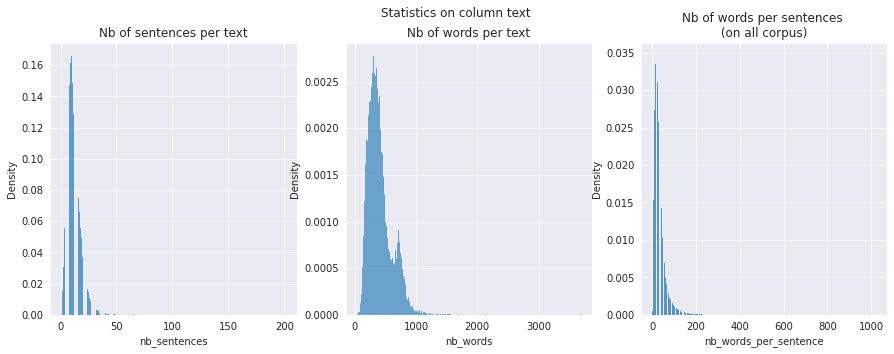

In [ ]:
stats_lengths(df_orangesum_train, text_column='text')

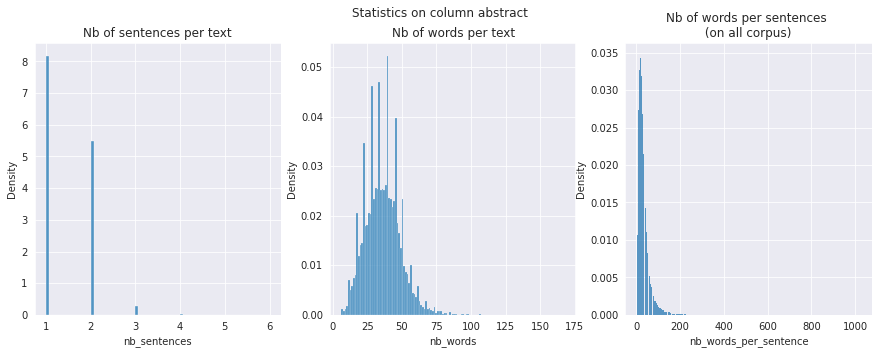

In [ ]:
stats_lengths(df_orangesum_train, text_column='abstract')

↪ The articles and summaries are relatively shorts, the summaries mainly containing one or two sentences (first columns)

↪ The number of words per text (second column) justifies the choice made in the pre-processing section for the padding : we have chosen to keep 600 words per text and 60 per summary, which seems reasonable regarding these statistics.

↪ The number of words per sentence (third column) is similar for both articles and summaries. It can then be reasonable to think that extractive methods can have sense to deal with this corpus, as by extracting sentences from the articles to build our summaries could allow us to obtain a structure similar to the one of the summaries.

### Vocabulary & word distributions :

**1. Word distribution :**

Here are some important numbers concerning the vocabulary in OrangeSum (training dataset), given the fact that stopwords are excluded from all the vocabularies.

In [ ]:
threshold = None
vocabulary_orangesum_article_ = vocab_update(dataset_orangesum['train'], text_features='input', remove_stopwords=True, threshold=threshold)
vocabulary_orangesum_abstract_ = vocab_update(dataset_orangesum['train'], text_features='target', remove_stopwords=True, threshold=threshold)

  0%|          | 0/21401 [00:00<?, ?it/s]

  0%|          | 0/21401 [00:00<?, ?it/s]

In [ ]:
nb_words_text, nb_words_abstract = vocabulary_orangesum_article_['nbwords'], vocabulary_orangesum_abstract_['nbwords']
print(f"Number of words in OrangeSum (texts) vocabulary : {nb_words_text}")
print(f"Number of words in OrangeSum (abstract) vocabulary : {nb_words_abstract} (ie {(nb_words_abstract/nb_words_text)*100:.2f}% of text vocabulary)")

Number of words in OrangeSum (texts) vocabulary : 188084
Number of words in OrangeSum (abstract) vocabulary : 38448 (ie 20.44% of text vocabulary)


In [ ]:
def word_distribution (vocabulary, print_most_frequents = None, plot_title=None) : 
    """
    Plot word distribution within a given vocabulary
    If print_most_frequents is an int, also print the print_most_frequents most frequent words
    """

    dist_words = np.fromiter(vocabulary['counts'].values(), dtype='int')
    dist_words_df = pd.DataFrame({'counts' : dist_words})
    nb_total = dist_words_df['counts'].sum()
    dist_words_df['freq'] = dist_words_df['counts'].apply(lambda x: x/nb_total)
    dist_words_df = dist_words_df.sort_values('freq', ascending=False)

    # Plot word distributions :
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xscale('log')  # Using log scale
    ax.set_yscale('log')
    ax.plot(list(range(dist_words_df.shape[0])),dist_words_df['freq'])
    ax.set_title('Word distribution' if plot_title is None else plot_title)
    ax.set_xlabel('log(rank)')
    ax.set_ylabel('log(frequency)')
    plt.show()

    # Print most frequent words : 
    if print_most_frequents is not None :
        indices = np.argsort(dist_words)[:-print_most_frequents:-1]
        most_frequents = np.array(list(vocabulary['stoi'].keys()))[indices]
        print('Most frequent words :')
        print(most_frequents)


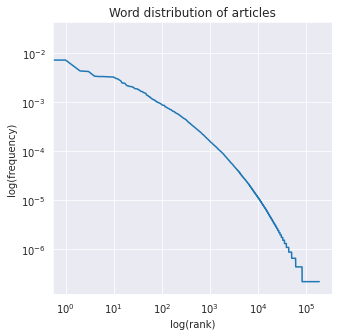

Most frequent words :
['a' 'plus' 'cette' 'cest' 'france' 'selon' 'dun' 'ans' 'fait' 'dune'
 'deux' 'comme' 'quil' 'depuis' 'après' 'tout' 'être' 'ministre' 'faire'
 'personnes' 'très' 'aussi' 'contre' 'si' 'président' 'alors' 'avoir'
 'sest' 'dont' 'entre' 'également' 'où' 'avant' 'atil' 'gouvernement'
 'sans' 'encore' 'plusieurs' 'paris']


In [ ]:
word_distribution(vocabulary_orangesum_article_, print_most_frequents=40, plot_title='Word distribution of articles') 

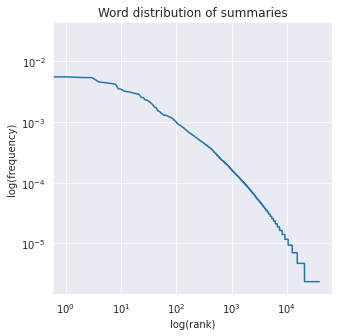

Most frequent words :
['a' 'france' 'après' 'plus' 'selon' 'dun' 'ans' 'dune' 'ministre' 'lundi'
 'deux' 'mardi' 'mercredi' 'jeudi' 'paris' 'depuis' 'vendredi' 'contre'
 'fait' 'président' 'dimanche' 'sest' 'samedi' 'coronavirus' 'avoir'
 'annoncé' 'cette' 'gouvernement' 'alors' 'premier' 'quil' 'plusieurs'
 'macron' 'français' 'comme' 'lors' 'mois' 'personnes' 'être']


In [ ]:
word_distribution(vocabulary_orangesum_abstract_, print_most_frequents=40, plot_title='Word distribution of summaries') 

↪ A first remark is that we do not obtain the Zipf's law as clearly as in lab1 for instance, but the word distributions for summaries and articles seems to be similar, even if the summaries' vocabulary is smaller.

↪ A surprising remark is that, in the most frequent words for both summaries and articles, there are still some 'stopwords', maybe due to the `word_tokenize` procedure (there is still words such as "dun", "a", "sest", ...)

↪ The more important to notice in these outputs is that, within the most frequent words, the politic's topic is really present, with words such as "president", "gouvernement", "ministre". So we may think that our models, above all abstractive ones, which are trained as supervised methods, should be better in summarizing politics' articles than more factual sport ones for instance. 

↪ Moreover, within the most frequent words, some specific words such as "coronavirus" or "Macron" are present, so we can see that our models may be adapted to nowadays' topics, as coronavirus and Macron are actual references, but our models may become obsolet to summarize older or future articles. This is one usual source of hardness in NLP to deal with new words, that's why pre-existing wide vocabularies may be more useful to train our models than the ones built from scratch.

**2. Numbers :**

In [ ]:
import re

In [ ]:
def stats_numbers (df, text_column='text') : 
    """
    Function that realizes statistics on numbers present in the given text columns.
    To simplify, we just concentrate on all numbers (without separating floats, int, ...)
    """ 
    # create an empty dataframe for our stats to not modify the input
    n = len(df)
    stats = pd.DataFrame({'idx':np.arange(n)})

    # extract numbers of texts :
    number_regex = r'[0-9]+[\.,\,]?[0-9]+'
    stats['numbers'] = df[text_column].apply(lambda x : list(re.findall(number_regex, x)))
    stats['nb_numbers'] = stats['numbers'].apply(lambda x : len(x))

    # Plot : 
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    sns.histplot(data=stats, x="nb_numbers", ax=ax, stat='density')
    ax.set_title(f'Nb of numbers per text in text column {text_column}')
    plt.show()

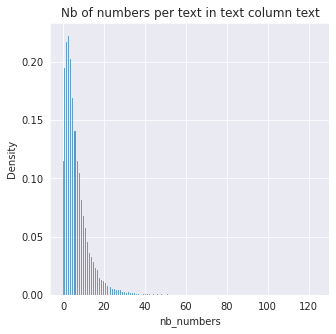

In [ ]:
stats_numbers(df_orangesum_train)

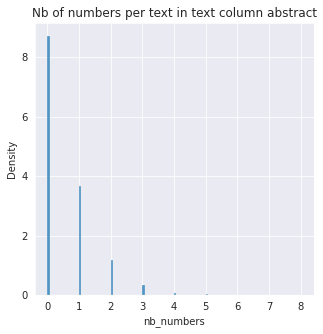

In [ ]:
stats_numbers(df_orangesum_train, text_column='abstract')

↪ The numbers are not that much present in the articles and summaries, regarding the fact that the number of words per article is up to 600 and per summary is up to 60.

↪ However, our extractive methods can allow to easily extract numbers to put in the summary, but our abstractive models (at least for our from scratch tests), may have issues to deal with numbers are they are not part of a vocabulary.

### Topic description using a pretrained model :

To have an idea of the main topic of the articles of our corpus could be useful, for instance to compare the performance on our summarization model on different type of subjects that may be more or less factual, or to see if the main topic associated to our article is the same than the one associated to our generated summary. 

We used an already existing model found on Hugging Face : [`flaubert-mlsum-topic-classification`](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+des+canards+ont+envahit+le+parlement.). This is a classification model, trained on the french MLSUM dataset, which outputs a topic category within : "Culture, Economie, Education, Environnement, Justice, Opinion, Politique, Société, Sport, Technologie". 

Note that we didn't implement the topic modelization by ourselves as it was not the main purpose of our project, but we could have implemented an unsupervised topic modelling such as LDA ([Latent Dirichlet Allocation ](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)), which consists in finding the .

We follow here the instructions given in the [Hugging Face page](https://huggingface.co/lincoln/flaubert-mlsum-topic-classification?text=La+bourse+de+paris+en+forte+baisse+apr%C3%A8s+que+des+canards+ont+envahit+le+parlement.), so we do not have to deal with the pre-processing and tokenization, we re use the one given with the model :

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline

In [ ]:
model_name = 'lincoln/flaubert-mlsum-topic-classification'

loaded_tokenizer = AutoTokenizer.from_pretrained(model_name)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_name)

topic_classifier = TextClassificationPipeline(model=loaded_model, tokenizer=loaded_tokenizer)

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/561k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/305 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

In [ ]:
def topic_description (df, text_column='text', title_plot=None) : 
    """
    Use flaubert-mlsum-topic-classification to assign a main topic to each article in df[text_column],
    stored in df[f'main_topic_{text_column}'],
    and plot the proportion of each topic in the corpus.

    !!! : execution might be really long...
    """

    # Creation of a new column in df to store the main topic : 
    new_column = 'main_topic_'+text_column
    df[new_column] = df[text_column].progress_apply(lambda x : topic_classifier(x, truncation=True)[0]['label'])

    # Computation of proportion of each topic in the corpus :
    stats_topics = df[[new_column,text_column]].groupby(new_column).count().reset_index()
    stats_topics[text_column] = stats_topics[text_column] *100 / stats_topics[text_column].sum() 

    # Plot in horizontal barplot :
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    sns.barplot(data=stats_topics, x=text_column, y=new_column, orient='h', ax=ax, palette="Set2")
      # Titles :
    ax.set_xlabel('Proportion in the corpus (%)')
    ax.set_ylabel('Main topic')
    if title_plot is None :
        fig.suptitle(f'Main topic of column {text_column} in the corpus')
    else :
        fig.suptitle(title_plot)
    # Annotations : 
    for p in ax.patches:
        width = p.get_width()
        plt.text(4+p.get_width(), p.get_y()+0.55*p.get_height(),
                '{:1.1f}%'.format(width), ha='center', va='center')

Run on the $500$ first news article of our train set (computation time being very long...) :

100%|██████████| 500/500 [10:52<00:00,  1.30s/it]


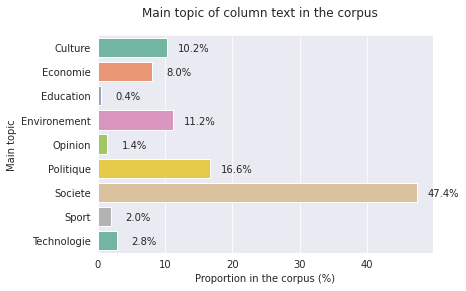

In [ ]:
df_orangesum_train_500 = df_orangesum_train.copy()[:500] 
topic_description(df_orangesum_train_500) 

$\hookrightarrow$ It seems that, at least in the first articles of the corpus, the main topics are society and politics, that is to say mainly "abstractive" and "subjective" subjects. It may be harder for the model to understand the opinion within the articles, it can be something to evaluate on our models. Note that this is in adequation with the observation made on the most frequent words in the previous subsection.

We can also try to see if the main topic attributed to the articles are the same to the ones attributed to the abstracts :

In [ ]:
df_orangesum_train_500['main_topic_abstract'] = df_orangesum_train_500['abstract'].progress_apply(lambda x : topic_classifier(x, truncation=True)[0]['label'])
prop_match = (df_orangesum_train_500['main_topic_text']==df_orangesum_train_500['main_topic_abstract']).mean()*100

print(f'Proportion of article-summary pairs with same main topic in the 500 first articles : {prop_match} %')

100%|██████████| 500/500 [01:30<00:00,  5.54it/s]

Proportion of article-summary pairs with same main topic in the 500 first articles : 74.8 %


↪ This is quite satisfying, and may be a possible idea to evaluate our generated summaries in the experiments' section.

## Extractive models :

 ### TextRank algorithm

The first "naive" approach to address the text summarization task is an **extractive** method. It's an unsupervised model, which will try to identify the most revelant sentences in a given document, and will build a summary by extracting them. We will then obtain a summary composed of a "patchwork" of sentences from the article, we won't "generate new sentences".



**TextRank algorithm :**

We have chosen to implement the [TextRank](https://aclanthology.org/W04-3252.pdf) algorithm, which is similar to the PageRank algorithm proposed by Google, but applied here to the scoring of the sentences of a text. Here are the main steps of the algorithm, which will turn our problem into a graph problem :  

1. Identify text units that best define the task at hand, that is to say the sentences in our case, and add them as vertices in our graph.
2. Compute a similarity matrix between the sentences of our text, which will correspond to the weights given to each edges of our graph. Here are some possibilities for the choice of similarity measure between two sentences $S_i = w^i_1 ... w^i_{N_i}$ and $S_j = w^j_1 ... w^j_{N_j}$ :     
  * The similarity measure initially proposed by the TextRank article simply corresponds to the lenght of the overlapping content of both sentences : $$Similarity(S_i,S_j) = \frac{|\{w_k : w_k \in S_i \& w_k \in S_j \}|}{\log(|S_i|) + \log(|S_j|)}$$
  * If we use embedding techniques to transform our sentences into vectors $s_i, s_j \in \mathbb{R}^d$, we can for instance use the cosine similarity, defined by : $$Similarity(s_i,s_j) = \frac{<s_i,s_j>}{\|s_i\|\|s_j\|}$$

3. Iterate the graph-based ranking algorithm until convergence :
  - The score attributed to each sentence $S_i$ according to the weight of its edges defined in the previous step can be summed up into : $$Score(S_i) = (1-\gamma) + \gamma * \sum_{j \neq i} \left( \frac{Similarity(S_i,S_j)}{ \sum_{k \neq j} Similarity(S_k,S_j) } \right) Score(S_j) $$ with $\gamma \in (0,1)$ (authors recommand to choose $\gamma=0.85$). 
  - The previous score being non explicit, we initialize the scores of every sentence randomly, and apply the previous formula until convergence to obtain the final scores. 

4. Sort vertices based on their final score. Build then a summary by keeping the $x$ sentences with highest score, $x$ being chosen by the user.

---
**Pros :**
- The summary is only constructed regarding the given article, no additionnal training on an entire dataset is needed.

**Cons :**
- Sentences extracted from the text, which results in a "patchwork" not always coherent (pronouns, ...)
- May have issues for text composed of very long sentences.
---





#### Model definition :

In [ ]:
from gensim.models import Word2Vec
from scipy import spatial

In [ ]:
class TextRank () :

    def __init__ (self, gamma=0.85, max_iter=100, tol=1e-16) :
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol


    def get_similarity_matrix (self, text) : 
        """
        Implementation of the following "simple" method : 
          - use Word2Vec with 1 embedding dimension on each word of each sentence
            as a Seq2Vec model
          - use cosine similarity on the obtain sequences' vectors
        """
        # Use our previously defined cleaning function :
        tok_text = tokenize_clean_text(text)

        # Construction of text embeddings :
        w2v = Word2Vec(tok_text, size=1, min_count=1, iter=1000)
        text_embeddings=[[w2v[word][0] for word in words] for words in tok_text]
        max_len=max([len(tokens) for tokens in tok_text])
        text_embeddings = [np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in text_embeddings]

        # Construction of similarity matrix : 
        nb_sentences = len(tok_text)
        similarity_matrix = np.zeros((nb_sentences,nb_sentences))
        for i,row_embedding in enumerate(text_embeddings):
            for j,column_embedding in enumerate(text_embeddings):
                similarity_matrix[i][j]=1-spatial.distance.cosine(row_embedding,column_embedding)

        return similarity_matrix


    def get_scores (self, similarity_matrix) : 
        # similarity matrix : SM, symmetric, with SM_{ij} = Similarity(S_i, S_j) and SM_{ii} = 0 (shape n x n)
        # output : scores attributed to each sentence (shape n)

        n = similarity_matrix.shape[0]
        # normalization of the similarity matrix by column :
        similarity = similarity_matrix / similarity_matrix.sum(axis=0)

        # Initialization of the scores : 
        scores = np.full(shape=n, fill_value=1/n) 
        error,iter = self.tol + 1, 0

        # Iteration of the algorithm : 
        while (error > self.tol) and (iter < self.max_iter) : 
            last_scores = scores.copy()

            # Iteration of the score formula :
            scores = np.dot(similarity , scores) * self.gamma + (1-self.gamma)

            # Computation of the error : 
            error = np.sum(abs(scores-last_scores))
            iter += 1

        # Normalization of the final scores :
        scores = scores / scores.sum()
        return scores

    def print_scores (self, text_sentences, scores) : 
        """
        Print given text_sentences with colors coresponding to their scores. 
        """
        on_colors = ['on_blue', 'on_cyan', 'on_green', 'on_yellow', 'on_magenta', 'on_red']

        indices = np.argsort(scores)

        # Attribution of colors :
        k_update = len(indices) // 6
        on_colors_ind = [0 for i in range(len(indices))]
        scores_bornes = []
        score_inf = 0
        on_color_id = 0
        k = 0
        for i in indices : 
          on_colors_ind[i] = on_color_id
          k += 1 
          if k >= k_update : 
            scores_bornes.append(f"{score_inf:.5f}-{scores[i]:.5f}")
            score_inf = scores[i]
            k = 0
            on_color_id +=1

        # Prints :
        print('Scale of scores :')
        print(' '.join( (colored(scores_bornes[k], 'white' , on_color) 
                        for k, on_color in enumerate(on_colors))))
        print('-'*200)
        print('\n'.join( (colored(text_sentences[k], 'white' , on_colors[on_colors_ind])
          for k, on_colors_ind in enumerate(on_colors_ind))))


    def summarize__ (self, text, nb_summary_seq = 2, print_score=False) : 
        similarity_matrix = self.get_similarity_matrix(text)
        scores = self.get_scores(similarity_matrix) 

        indices_best = np.argsort(scores)[:-(nb_summary_seq+1):-1]
        text_sentences = np.array(sent_tokenize(text))
        summary = ''.join(text_sentences[indices_best])

        if print_score : 
            self.print_scores(text_sentences, scores)

        return summary


#### Example of prediction : 

In [ ]:
text = dataset_orangesum['train'][2]['input']
summary_real = dataset_orangesum['train'][2]['target']

Generation of the summary  :

In [ ]:
summary_generated = TextRank().summarize__(text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
summary_real

'En 2020, les tribunaux d\'instance fusionnent avec ceux de grande instance pour former un unique "tribunal judiciaire". C\'est la principale mesure de la réforme de la Justice, portée par la garde des sceaux Nicole Belloubet.\n'

In [ ]:
summary_generated

'Alors que les particuliers pouvaient se présenter directement au greffe du tribunal d\'instance pour déposer leur requête, la réforme renforce le recours accru aux procédures dématérialisées et étend la représentation obligatoire par un avocat.Elle ne serait "pas étonnée" que le gouvernement ait souhaité "différer des annonces" selon les résultats électoraux de La République en marche dans les communes concernées, comme l\'écrivait Le Canard enchaîné dans une série d\'articles fin octobre.'

ROUGE scores between text and summary :

In [ ]:
Rouge().get_scores(summary_generated, summary_real, avg=True)

{'rouge-1': {'f': 0.18749999562717026,
  'p': 0.13846153846153847,
  'r': 0.2903225806451613},
 'rouge-2': {'f': 0.019230764829882663,
  'p': 0.014285714285714285,
  'r': 0.029411764705882353},
 'rouge-l': {'f': 0.18749999562717026,
  'p': 0.13846153846153847,
  'r': 0.2903225806451613}}

We can also print the scores attributed to each sentence of the initial text : 

In [ ]:
summary_generated = TextRank().summarize__(text, print_score=True)

Scale of scores :
0.00000-0.03562 0.03562-0.04170 0.04170-0.04295 0.04295-0.04392 0.04392-0.04448 0.04448-0.04497
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
La mesure est décriée par les avocats et les magistrats.
Juridictions de proximité par excellence, traitant les litiges du quotidien, les tribunaux d'instance s'apprêtent à fusionner avec les tribunaux de grande instance.
Cette réorganisation est l'une des principales mesures de la réforme de la justice, promulguée le 23 mars.
Les professionnels s'inquiètent d'une dévitalisation de ces petites juridictions et d'un accès plus restreint au juge.
Réforme de la justice : pourquoi les avocats, magistrats et greffe sont-ils en colère ?par Le Dauphiné LibéréDepuis 1958, les tribunaux d'instance (TI) et les tribunaux de grande instance (TGI) se partageaient les contentieux civils, sel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


### Comparaison with a clustering algorithm based on BERT's embeddings: 

BERT (Bidirectional Encoder Representations from Transformers) is a transformer presented by researchers at Google AI Language. It is a pre-trained model that is naturally bidirectional and that can be useful in many natural language tasks. We decided to compare our model for summarization to the BERT model which is widely used. The BERT Model is pre-trained in English so we used the FlauBERT model for embedding which is pre-trained in French. Then we use the Kmeans clustering approach to cluster the sentences with the same context together. We choose only one sentence per cluster for the summary, the one with the lowest distance from centroid.

In [ ]:
!pip install bert-extractive-summarizer

In [ ]:
from nltk.cluster import KMeansClusterer
from scipy.spatial import distance_matrix
from transformers import FlaubertModel, FlaubertTokenizer

In [ ]:
flaubert, log = FlaubertModel.from_pretrained('flaubert/flaubert_base_uncased', output_loading_info=True)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_uncased', do_lowercase=False)

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/524M [00:00<?, ?B/s]

Some weights of the model checkpoint at flaubert/flaubert_base_uncased were not used when initializing FlaubertModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/896k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

In [ ]:
class BERT_model () :

    def __init__ (self, gamma=0.85, max_iter=100, tol=1e-16) :
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol


    def get_embeddings (self, text) : 
        """
        Implementation of the following "simple" method : 
          - use flaubert for embedding dimension on each word of each sentence
            as a Seq2Vec model
          - use cosine similarity on the obtain sequences' vectors
        """
        # Use our previously defined cleaning function :
        sentences=nltk.sent_tokenize(text)
        sentences = [sentence.strip() for sentence in sentences] 
        data = pd.DataFrame(sentences)
        data.columns=['sentence']

        # Construction of text embeddings :

        sentences = [sentence.strip() for sentence in sentences] 
        text_embeddings=[torch.tensor([flaubert_tokenizer.encode(words)]) for words in sentences]
        text_embeddings[0]
        last_layer =[flaubert(text_embeddings[i])[0] for i in range(len(text_embeddings))] 
        cls_embedding = [last_layer[i][:, 0, :] for i in range(len(last_layer))] 
        sentence_embeddings = [cls_embedding[i].detach().numpy() for i in range(len(cls_embedding))] 
        liste_embeddings = [sentence_embeddings[i][0].tolist() for i in range(len(cls_embedding))] 
        data['embeddings']=liste_embeddings

        return data


    def get_cluster (self, data, num_clusters=10, iterations=25) : 
        
        X = np.array(data['embeddings'].tolist())
        kclusterer = KMeansClusterer(
                num_clusters, distance=nltk.cluster.util.cosine_distance,
                repeats=iterations,avoid_empty_clusters=True)
        assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
        data['cluster']=pd.Series(assigned_clusters, index=data.index)
        data['centroid']=data['cluster'].apply(lambda x: kclusterer.means()[x])

        return data
        
    def distance_from_centroid(self,row):
        #type of emb and centroid is different, hence using tolist below
        liste=[]
        for i in range(len(row)):
          m = np.expand_dims(np.array(row['centroid'][i]),1)
          n = np.expand_dims(np.array(row['embeddings'][i]),1)
          liste.append(distance_matrix(n, m)[0][0]) 
        return liste
        

    def summarize__ (self, text, nb_summary_seq = 2, print_score=False) : 
        embeddings = self.get_embeddings(text)
        cluster = self.get_cluster(embeddings) 
        cluster['distance_from_centroid'] = self.distance_from_centroid(cluster)
        summary=' '.join(cluster.sort_values('distance_from_centroid',ascending = True).groupby('cluster').head(1).sort_index()['sentence'].tolist())

        return summary

In [ ]:
text = dataset_orangesum['train'][2]['input']
bert_summary = BERT_model().summarize__(text)

[0.2565775527152525, 0.4149898551732881, 0.0, 0.026238261302997, 0.0664024018079622, 0.16620675098592208, 0.10398334399790632, 0.04058880973854273, 0.5797823472932206, 0.8574807278000662, 0.0, 0.6685420646935122, 0.014266401979004306, 0.1566451273047278, 0.04055170844993383, 0.0, 0.23308593169779646, 0.5674131499138368, 0.0, 0.014279454496825772, 0.5792523817106856, 0.396338034388365, 0.749695804002939, 1.0142828740990808]


In [ ]:
bert_summary

'Cette réorganisation est l\'une des principales mesures de la réforme de la justice, promulguée le 23 mars. Les professionnels s\'inquiètent d\'une dévitalisation de ces petites juridictions et d\'un accès plus restreint au juge. Réforme de la justice : pourquoi les avocats, magistrats et greffe sont-ils en colère ?par Le Dauphiné LibéréDepuis 1958, les tribunaux d\'instance (TI) et les tribunaux de grande instance (TGI) se partageaient les contentieux civils, selon une répartition essentiellement fondée sur le montant du litige. Exit aussi le juge d\'instance, qui s\'appellera désormais "juge des contentieux de la protection". Les deux principaux syndicats de magistrats dénoncent "le flou" autour de la question. La loi facilite la création de pôles spécialisés dans les départements ayant plusieurs tribunaux de grande instance et permet d\'attribuer des compétences supplémentaires aux tribunaux de proximité pour mieux "s\'adapter aux besoins particuliers des territoires", souligne le 

In [ ]:
L,N = dataset_orangesum['train'].shape
df1 = pd.DataFrame(columns=['summary_generated','bert_summary'])
for i in range(100):
  text = dataset_orangesum['train'][i+500]['input']
  summary_generated = TextRank().summarize__(text)
  bert_summary = BERT_model().summarize__(text)
  df_new_row = pd.DataFrame(data=np.array([[summary_generated,bert_summary]]), columns=['summary_generated','bert_summary'])
  df1 = pd.concat([df1,df_new_row], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

In [ ]:
df1

,summary_generated,bert_summary
0,""", insistait-il sur CNews.Eric Dupond-Moretti ...",Alors que la colère des féministes ne faiblit ...
1,"Ce n'est pas encore les vacances, mais ce prem...","Ce n'est pas encore les vacances, mais ce prem..."
2,"""Mercredi soir, Likalé (a) réussi à prendre Xi...",Sa naissance en janvier avait été la première ...
3,"Dans la nuit de jeudi à vendredi, pour la troi...",Des centaines de personnes se sont rassemblées...
4,Seuls 219 000 spectateurs ont assisté à cette ...,"Le chroniqueur Lamine Lezghad, révélé par l'ém..."
...,...,...
95,Je regarde dans mon rétroviseur pour voir ce q...,Le deuxième suspect placé en garde à vue après...
96,Quelque 100.000 m3 de liquide noirâtre (essent...,Un silo s'est effondré dans la nuit de lundi 4...
97,"""Cette analyse de données montre que nous devo...",L'exposition croissante de l'environnement aux...
98,"""J'ai été enceinte à 17 ans, mes parents ont e...","En plein débat sur la loi de bioéthique, la dé..."


In [ ]:
Rouge().get_scores(summary_generated, bert_summary, avg=True)

{'rouge-1': {'f': 0.16842104787590043,
  'p': 0.21621621621621623,
  'r': 0.13793103448275862},
 'rouge-2': {'f': 0.0194174708982951,
  'p': 0.023809523809523808,
  'r': 0.01639344262295082},
 'rouge-l': {'f': 0.12631578471800572,
  'p': 0.16216216216216217,
  'r': 0.10344827586206896}}

  0%|          | 0/100 [00:00<?, ?it/s]

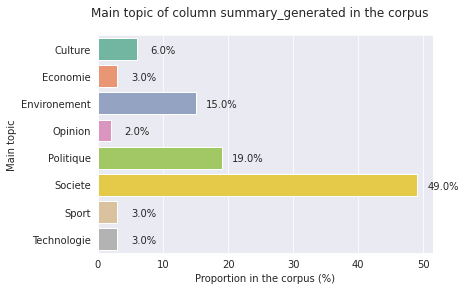

In [ ]:
 topic_description(df1, text_column='summary_generated')

  0%|          | 0/100 [00:00<?, ?it/s]

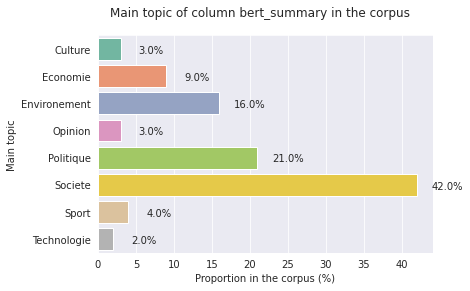

In [ ]:
topic_description(df1, text_column='bert_summary')

In [ ]:
n = len(df1)
stats_summary_generated = pd.DataFrame({'idx':np.arange(n)})
stats_summary_generated['nb_sentences'] = df1['summary_generated'].apply(lambda x : len(sent_tokenize(x, language='french')))
stats_summary_generated['nb_words'] = df1['summary_generated'].apply(lambda x : len(word_tokenize(x, language='french')))
stats_summary_generated.mean()

idx             49.50
nb_sentences     1.26
nb_words        60.28
dtype: float64

In [ ]:
n = len(df1)
stats_bert_summary = pd.DataFrame({'idx':np.arange(n)})
stats_bert_summary['nb_sentences'] = df1['bert_summary'].apply(lambda x : len(sent_tokenize(x, language='french')))
stats_bert_summary['nb_words'] = df1['bert_summary'].apply(lambda x : len(word_tokenize(x, language='french')))
stats_bert_summary.mean()

idx             49.50
nb_sentences     3.13
nb_words        94.95
dtype: float64

In [ ]:
stats_summary_generated.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


idx             49.50
nb_sentences     1.26
nb_words        60.28
dtype: float64

## Abstractive models

A more advanced approach to address text summarization aims at "generating" the summary, that is to say to produce a summary with new generated sentences that do not exist in the text to summarize. 

For this task, we may use Deep Learning models, with models based on Encoder-Decoder approaches, using RNNs or Transformers for instance. 


In [ ]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(f'Device : {device}')

Device : cuda


### Model(s) from scratch

As our main goal was to build a model capable of generating summaries without using sentences already in the corpus, our main efforts were spent in developping such sophisticated models, mainly known as "abstractive models", leveraging Deep Learning architectures. 

Nonetheless, due to hardware constraints (insufficient RAM) and connectivity issues (runtime error in Colab) most of our attempts were initially unsuccessful. In the following lines of code, we propose our best results among the abstractive models we have built and trained from scratch, leaving the unsuccessful ones below in the appendix. 

Please note that the following model has been trained locally for the constraints mentioned above and finally merged into this Colab Notebook (please refer to /content/NLP-summarization-of-French-written-documents/NLP Abstractive Approach_Final.ipynb for the version with original output). We also provide the checkpoint files containing the tensorflow graph that collects the weights of the best model we got during the training phase (available here: /content/NLP-summarization-of-French-written-documents/checkpoints). 
As a final remark, the training has been interrupted manually after 6 hours, due to shortage of time, at the epoch 5/200. 

In [ ]:
!git clone https://github.com/gdeni89/NLP-summarization-of-French-written-documents.git

Cloning into 'NLP-summarization-of-French-written-documents'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 67 (delta 27), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
print('TensorFlow Version: {}'.format(tf.__version__))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

TensorFlow Version: 1.13.1


In [ ]:
df_test_OS = pd.DataFrame(dataset_orangesum['test'])
df_train_OS = pd.DataFrame(dataset_orangesum['train'])

#### Pre-processing

In [ ]:
import nltk
nltk.download('stopwords')
  
# Clean the summaries and texts
clean_target = []
for target in df_train_OS.target:
    clean_target.append(clean_text(target, remove_stopwords=False))
print("Summaries are complete.")

clean_input = []
for input in df_train_OS.input:
    clean_input.append(clean_text(input))
print("Texts are complete.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Summaries are complete.
Texts are complete.


In [ ]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [ ]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, clean_target)
count_words(word_counts, clean_input)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 111529


In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("french"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [ ]:
from torchtext.vocab import FastText, vocab

In [ ]:
# Load of pretrained embeddings vectors :
pretrained_vectors_fasttext = FastText(language='fr')

.vector_cache/wiki.fr.vec: 3.03GB [01:00, 49.8MB/s]                            
100%|██████████| 1152449/1152449 [02:23<00:00, 8011.00it/s]


In [ ]:
pretrained_vectors_words = pretrained_vectors_fasttext.stoi.keys()
pretrained_vectors_values = pretrained_vectors_fasttext.stoi.values()

In [ ]:
import numpy as np
import timeit

embeddings_index = {}
word = pretrained_vectors_fasttext.stoi.keys()
for word in word_counts:
    embedding = pretrained_vectors_fasttext[word]
    embeddings_index[word] = embedding
        
print('Word embeddings:', len(embeddings_index))

Word embeddings: 111529


In [ ]:
# Find the number of words that are missing from CN, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from fastText:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from fastText: 0
Percent of words that are missing from vocabulary: 0.0%


In [ ]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in CN

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 111529
Number of words we will use: 111533
Percent of words we will use: 100.0%


In [ ]:
# Need to use 300 for embedding dimensions to match fastText vectors.
embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in fT, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

111533


In [ ]:
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [ ]:
# Apply convert_to_ints to clean_target and clean_input
word_count = 0
unk_count = 0

int_target, word_count, unk_count = convert_to_ints(clean_target, word_count, unk_count)
int_input, word_count, unk_count = convert_to_ints(clean_input, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 5339165
Total number of UNKs in headlines: 0
Percent of words that are UNK: 0.0%


In [ ]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [ ]:
lengths_target = create_lengths(int_target)
lengths_input = create_lengths(int_input)

print("Summaries:")
print(lengths_target.describe())
print()
print("Texts:")
print(lengths_input.describe())

Summaries:
             counts
count  21401.000000
mean      34.393112
std       12.316238
min        3.000000
25%       26.000000
50%       34.000000
75%       42.000000
max      164.000000

Texts:
             counts
count  21401.000000
mean     216.088921
std      106.650884
min       11.000000
25%      142.000000
50%      192.000000
75%      260.000000
max     1884.000000


In [ ]:
# Inspect the length of "input"
print(np.percentile(lengths_input.counts, 90))
print(np.percentile(lengths_input.counts, 95))
print(np.percentile(lengths_input.counts, 99))

377.0
417.0
525.0


In [ ]:
# Inspect the length of "target"
print(np.percentile(lengths_target.counts, 90))
print(np.percentile(lengths_target.counts, 95))
print(np.percentile(lengths_target.counts, 99))

49.0
54.0
70.0


In [ ]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [ ]:
# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove texts that include too many UNKs

sorted_target = []
sorted_input = []
max_input_length = 377
max_target_length = 70
min_length = 2
unk_input_limit = 1
unk_target_limit = 0

for length in range(min(lengths_input.counts), max_input_length): 
    for count, words in enumerate(int_target):
        if (len(int_target[count]) >= min_length and
            len(int_target[count]) <= max_target_length and
            len(int_input[count]) >= min_length and
            unk_counter(int_target[count]) <= unk_target_limit and
            unk_counter(int_input[count]) <= unk_input_limit and
            length == len(int_input[count])
           ):
            sorted_target.append(int_target[count])
            sorted_input.append(int_input[count])
        
# Compare lengths to ensure they match
print(len(sorted_target))
print(len(sorted_input))

19058
19058


#### Defining the model

The architecture of abstractive models is a more sophisticated NN structure which is typically made up by two different parts: an encoder, which understands the inputs and represent them in an internal representation, and a decoder, which is fed by the encoder.
The role of the encoder is to generate an annotation for every word in an input sentence of length T words. The role of the decoder is to produce the target words by focusing on the most relevant information contained in the source sentence. For this purpose, it usually makes use of an attention mechanism. 

Conventional encoder-decoder architectures encoded every source sentence into a fixed-length vector, irrespective of its length, from which the decoder would then generate an output. This made it difficult for the neural network to cope with long sentences, essentially resulting in a performance bottleneck. To address this issue, attention mechanisms were in fact proposed, initially by Cho et al. (2014) and Sutskever et al. (2014), who had also employed an RNN encoder-decoder framework, specifically by encoding a variable-length source sentence into a fixed-length vector. The latter would then be decoded into a variable-length target sentence. In 2014, Bahdanau et al. argued in their work that this encoding of a variable-length input into a fixed-length vector squashes the information of the source sentence, irrespective of its length, causing the performance of a basic encoder-decoder model to deteriorate rapidly with an increasing length of the input sentence. The approach they propose, on the other hand, replaces the fixed-length vector with a variable-length one, to improve the translation performance of the basic encoder-decoder model.

For the purpose at hand, we will then use a two-layered bidirectional RNN with LSTMs in the encoder and a decoder which is a seq2seq model with two layers, each with an LSTM, enriched with a Bahdanau attention on the target data and it is inspired by the following implementation (https://github.com/theamrzaki/text_summurization_abstractive_methods).


In [ ]:
def model_inputs():
    '''Create placeholders for inputs to the model'''
    
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    summary_length = tf.placeholder(tf.int32, (None,), name='summary_length')
    max_summary_length = tf.reduce_max(summary_length, name='max_dec_len')
    text_length = tf.placeholder(tf.int32, (None,), name='text_length')

    return input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length

In [ ]:
def process_encoding_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

In [ ]:
def encoding_layer(rnn_size, sequence_length, num_layers, rnn_inputs, keep_prob):
    '''Create the encoding layer'''
    
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer)):
            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, 
                                                    input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, 
                                                    input_keep_prob = keep_prob)

            enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                    cell_bw, 
                                                                    rnn_inputs,
                                                                    sequence_length,
                                                                    dtype=tf.float32)
    # Join outputs since we are using a bidirectional RNN
    enc_output = tf.concat(enc_output,2)
    
    return enc_output, enc_state

In [ ]:
def training_decoding_layer(dec_embed_input, summary_length, dec_cell, initial_state, output_layer, 
                            vocab_size, max_summary_length):
    '''Create the training logits'''
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                        sequence_length=summary_length,
                                                        time_major=False)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 

    training_logits, _ , _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                           output_time_major=False,
                                                           impute_finished=True,
                                                           maximum_iterations=max_summary_length)
    return training_decoder

In [ ]:
def inference_decoding_layer(embeddings, start_token, end_token, dec_cell, initial_state, output_layer,
                             max_summary_length, batch_size):
    '''Create the inference logits'''
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings,
                                                                start_tokens,
                                                                end_token)
                
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        initial_state,
                                                        output_layer)
                
    inference_logits, _ , _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                            output_time_major=False,
                                                            impute_finished=True,
                                                            maximum_iterations=max_summary_length)
    
    return inference_decoder

In [ ]:
def decoding_layer(dec_embed_input, embeddings, enc_output, enc_state, vocab_size, text_length, summary_length, 
                   max_summary_length, rnn_size, vocab_to_int, keep_prob, batch_size, num_layers):
    '''Create the decoding cell and attention for the training and inference decoding layers'''
    
    for layer in range(num_layers):
        with tf.variable_scope('decoder_{}'.format(layer)):
            lstm = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            dec_cell = tf.contrib.rnn.DropoutWrapper(lstm, 
                                                     input_keep_prob = keep_prob)
    
    output_layer = Dense(vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    attn_mech = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                  enc_output,
                                                  text_length,
                                                  normalize=False,
                                                  name='BahdanauAttention')

    dec_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell,
                                                          attn_mech,
                                                          rnn_size)
            
    #initial_state = tf.contrib.seq2seq.AttentionWrapperState(enc_state[0],
    #                                                                _zero_state_tensors(rnn_size, 
    #                                                                                    batch_size, 
    #                                                                                    tf.float32)) 
    initial_state = dec_cell.zero_state(batch_size=batch_size,dtype=tf.float32).clone(cell_state=enc_state[0])

    with tf.variable_scope("decode"):
        training_decoder = training_decoding_layer(dec_embed_input, 
                                                  summary_length, 
                                                  dec_cell, 
                                                  initial_state,
                                                  output_layer,
                                                  vocab_size, 
                                                  max_summary_length)
        
        training_logits,_ ,_ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                  output_time_major=False,
                                  impute_finished=True,
                                  maximum_iterations=max_summary_length)
    with tf.variable_scope("decode", reuse=True):
        inference_decoder = inference_decoding_layer(embeddings,  
                                                    vocab_to_int['<GO>'], 
                                                    vocab_to_int['<EOS>'],
                                                    dec_cell, 
                                                    initial_state, 
                                                    output_layer,
                                                    max_summary_length,
                                                    batch_size)
        
        inference_logits,_ ,_ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                  output_time_major=False,
                                  impute_finished=True,
                                  maximum_iterations=max_summary_length)

    return training_logits, inference_logits

In [ ]:
def seq2seq_model(input_data, target_data, keep_prob, text_length, summary_length, max_summary_length, 
                  vocab_size, rnn_size, num_layers, vocab_to_int, batch_size):
    '''Use the previous functions to create the training and inference logits'''
    
    # Use Numberbatch's embeddings and the newly created ones as our embeddings
    embeddings = word_embedding_matrix
    
    enc_embed_input = tf.nn.embedding_lookup(embeddings, input_data)
    enc_output, enc_state = encoding_layer(rnn_size, text_length, num_layers, enc_embed_input, keep_prob)
    
    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embed_input = tf.nn.embedding_lookup(embeddings, dec_input)
    
    training_logits, inference_logits  = decoding_layer(dec_embed_input, 
                                                        embeddings,
                                                        enc_output,
                                                        enc_state, 
                                                        vocab_size, 
                                                        text_length, 
                                                        summary_length, 
                                                        max_summary_length,
                                                        rnn_size, 
                                                        vocab_to_int, 
                                                        keep_prob, 
                                                        batch_size,
                                                        num_layers)
    
    return training_logits, inference_logits

In [ ]:
def pad_sentence_batch(sentence_batch):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [vocab_to_int['<PAD>']] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [ ]:
def get_batches(summaries, texts, batch_size):
    """Batch summaries, texts, and the lengths of their sentences together"""
    for batch_i in range(0, len(texts)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        texts_batch = texts[start_i:start_i + batch_size]
        pad_summaries_batch = np.array(pad_sentence_batch(summaries_batch))
        pad_texts_batch = np.array(pad_sentence_batch(texts_batch))
        
        # Need the lengths for the _lengths parameters
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        
        pad_texts_lengths = []
        for text in pad_texts_batch:
            pad_texts_lengths.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lengths, pad_texts_lengths

In [ ]:
# Set the Hyperparameters
epochs = 200
batch_size = 64
rnn_size = 256
num_layers = 2
learning_rate = 0.005
keep_probability = 0.75

In [ ]:
# Build the graph
train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length = model_inputs()

    # Create the training and inference logits
    training_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                      targets, 
                                                      keep_prob,   
                                                      text_length,
                                                      summary_length,
                                                      max_summary_length,
                                                      len(vocab_to_int)+1,
                                                      rnn_size, 
                                                      num_layers, 
                                                      vocab_to_int,
                                                      batch_size)
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_logits.rnn_output, 'logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
    
    # Create the weights for sequence_loss
    masks = tf.sequence_mask(summary_length, max_summary_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
print("Graph is built.")


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Graph is built.


Training the model

In the training of the model, we have use fairly standard hyperparameters, with the initial intention to fine tune them based on the output we would have got from the training. 
Unfortunately, the full training of this model would require a non-negligible number of hours of computation even if we considered a priori this potential issue by reducing the embedding index to just match the words in the corpus and by training a subset of the initial texts.  


In [ ]:
# Subset the data for training
start = 10000
end = start + 8000
sorted_target_short = sorted_target[start:end]
sorted_input_short = sorted_input[start:end]
print("The shortest text length:", len(sorted_input_short[0]))
print("The longest text length:",len(sorted_input_short[-1]))

The shortest text length: 186
The longest text length: 331


In order to track the training of the model we use some checkpoint to store the results we obtain at each epoch, by leveraging on the graph functionalities offered by TensorFlow. This would allow us and the user to restore training from the point left by simply recalling those files, that we enclose in the github repository and have anyway a fairly large size (approx. 1GB). 

In [ ]:
# Train the Model
learning_rate_decay = 0.95
min_learning_rate = 0.01 #0.0005
display_step = 20 # Check training loss after every 20 batches
stop_early = 0 
stop = 6 #3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 3 # Make 3 update checks per epoch
update_check = (len(sorted_input_short)//batch_size//per_epoch)-1

update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model

  
tf.reset_default_graph()
checkpoint = "C:/Users/Giuseppe/Desktop/NLP/best_model.ckpt"  
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    # loader = tf.train.import_meta_graph(checkpoint + '.meta')
    # loader.restore(sess, checkpoint)
    #sess.run(tf.local_variables_initializer())

    for epoch_i in range(1, epochs+1):
        update_loss = 0
        batch_loss = 0
        for batch_i, (summaries_batch, texts_batch, summaries_lengths, texts_lengths) in enumerate(
                get_batches(sorted_target_short, sorted_input_short, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: texts_batch,
                 targets: summaries_batch,
                 lr: learning_rate,
                 summary_length: summaries_lengths,
                 text_length: texts_lengths,
                 keep_prob: keep_probability})

            batch_loss += loss
            update_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_input_short) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0
                
                saver = tf.train.Saver() 
                saver.save(sess, checkpoint)
                
            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss for this update:", round(update_loss/update_check,3))
                summary_update_loss.append(update_loss)
                
              
                  
                # If the update loss is at a new minimum, save the model
                if update_loss <= min(summary_update_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                update_loss = 0
            
                    
        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break
    saver.save(sess, checkpoint)

In [ ]:
checkpoint = '/content/NLP-summarization-of-French-written-documents/checkpoints/best_model.ckpt'

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)
    names = []
    [names.append(n.name) for n in loaded_graph.as_graph_def().node]
names

OSError: ignored

#### Generating new summaries

The output we propose down below is coming from the original notebook referenced above. 

The code below is not directly runnable in Colab due to an unexpected error in the loading of the checkpoint files that we could not debug (we presume it being due to a “git push” command launched via “git lfs” that might have had an impact on the format of the files. If this would be the case, we remain available in sharing them in a different way). 

As the model is trained just for the first 5 epochs out of the 200 we planned to run, the results are far to produce an output that is satisfactory from a linguistic point of view. Nonetheless, by launching several trainings over a growing sample and with more demanding hyperparameters, we have noticed a significant improvement in the performance of the model, which let us confidently believe that the model could perform well should it be fully trained. For the above reasons, we keep the following output as illustrative example and we deem not fair to compare its results with the other models that are fully trained instead.  


In [ ]:
def text_to_seq(text):
    '''Prepare the text for the model'''
    
    text = clean_text(text)
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]

In [ ]:
# Create our own summaries from the dataset

#text = text_to_seq(input_sentence)
random = np.random.randint(0,len(clean_input))
input_sentence = clean_input[random]
text = text_to_seq(clean_input[random])

checkpoint = checkpoint = '/content/NLP-summarization-of-French-written-documents/checkpoints/best_model.ckpt'

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    text_length = loaded_graph.get_tensor_by_name('text_length:0')
    summary_length = loaded_graph.get_tensor_by_name('summary_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    #Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      summary_length: [np.random.randint(5,50)], 
                                      text_length: [len(text)]*batch_size,
                                      keep_prob: 1.0})[0] 

# Remove the padding from the tweet
pad = vocab_to_int["<PAD>"] 

print('Original Text:', df_train_OS.input[random])
print('Original summary:', df_train_OS.target[random])#clean_summaries[random]

print('\nText')
#print('  Word Ids:    {}'.format([i for i in text]))
print('  Input Words: {}'.format(" ".join([int_to_vocab[i] for i in text])))

print('\nSummary')
#print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))
print('  Response Words: {}'.format(" ".join([int_to_vocab[i] for i in answer_logits if i != pad])))

OSError: ignored

#### Example of prediction :

In [ ]:
##Example of the output of the trained model
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#INFO:tensorflow:Restoring parameters from C:/Users/Giuseppe/Desktop/NLP/best_model.ckpt
#Original Text: Mardi 18 juin, à l'occasion d'une commémoration de l'appel du 18 juin à Evreux dans l'Eure, une vingtaine de jeunes engagés au sein du Service national universel (SNU) ou cadets de la défense, ont été victimes de malaises après être restés debout en plein soleil. Ces jeunes, habillés en uniforme du SNU (casquette, polo blanc et pantalon noir), devaient rester immobiles pendant toute la cérémonie sur les marches de l'hôtel de ville, indique France Bleu Normandie. Or la température ressentie a dépassé les 31 degrés mardi. SNU : les soldats de la république - L'Info du Vrai du 18/06 - CANAL+par L'info du vraiAlors que les personnalités officielles dont le maire de la ville poursuivaient leurs discours, ces jeunes ont dû être pris en charge à l'intérieur de la mairie par les pompiers. Un véhicule du SAMU s'est également rendu sur place, ainsi que des effectifs de la police municipale qui ont aidé les jeunes à se réhydrater. Selon le maire Guy Lefrand, "deux ou trois jeunes" ont été plus sérieusement touchés. Dans un communiqué relayé par BFMTV, la préfecture de l'Eure évoque un "léger coup de chaud lié aux températures particulièrement élevées", mais aussi "une forme d'émotion liée au caractère solennel de la cérémonie". L'édile affirme au micro de France Bleu que les victimes ont "rapidement retrouvé la forme".

#Original summary: Rassemblés à l'occasion de la commémoration de l'appel du 18 juin, ces jeunes du Service national universel sont restés longtemps debout en plein soleil.


#Text
  #Input Words: mardi 18 juin occasion commémoration appel 18 juin evreux eure vingtaine jeunes engagés sein service national universel snu cadets défense victimes malaises après être restés debout plein soleil jeunes habillés uniforme snu casquette polo blanc pantalon noir devaient rester immobiles pendant toute cérémonie marches hôtel ville indique france bleu normandie or température ressentie a dépassé 31 degrés mardi snu soldats république info vrai 18 06 canal info vraialors personnalités officielles dont maire ville poursuivaient leurs discours jeunes dû être pris charge intérieur mairie pompiers véhicule samu également rendu place ainsi effectifs police municipale aidé jeunes réhydrater selon maire guy lefrand deux trois jeunes plus sérieusement touchés communiqué relayé bfmtv préfecture eure évoque léger coup chaud lié températures particulièrement élevées aussi forme émotion liée caractère solennel cérémonie édile affirme micro france bleu victimes rapidement retrouvé forme

#Summary
  #Response Words: les familles ont été placés en place à la mairie de paris a été placé en place à la mairie de paris

### Pre-trained BARTHez

The training of a model from scratch being really long, to be able to do better comparisons in the experiment section, we also used a BARTHez pre-trained.

BARTHez is a encoder-decoder model for French texts which uses the attention mechanism of transformers. It was presented together with OrangeSum dataset in the paper [*BARThez: a Skilled Pretrained French Sequence-to-Sequence Model*](https://arxiv.org/pdf/2010.12321.pdf), and a version pre-trained on a really wide french corpus is available in [HuggingFace](https://huggingface.co/moussaKam/barthez).

The main idea of this model is composed of a bidirectional encoder (similar as BART/BERT architectures), and a left-to-right auto-regressive decoder. Both the encoder and the decoder were pre-trained, and contains transformer's attention mechanism. 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
tokenizer_barthez = AutoTokenizer.from_pretrained("moussaKam/barthez")
model_barthez = AutoModelForSeq2SeqLM.from_pretrained("moussaKam/barthez-orangesum-abstract")

In [ ]:
model_barthez = model_barthez.eval()

In [ ]:
def summarize__barthez (text, max_length = 60) : 

    summary_generated = None 

    # the try part had to be added, because we had indexErrors, but the rest was provided in the documentation of BARTHez so we didn't find from were this error come from... 
    try : 

        # 1. Tokenization & Encoding the text : 
        text_encoded = torch.tensor(
            [tokenizer_barthez.encode(text, add_special_tokens=True)]
        )

        # Pad the text if needed (required for BARTHez) :
        if len(text_encoded) > 1024 : 
            text_encoded = text_encoded[:1024]

        # 2. Generation of (encoded) summary : 
        summary_generated_encoded = model_barthez.generate(text_encoded, max_length=max_length)[0]

        # 3. Decoding the summary : 
        summary_generated = tokenizer_barthez.decode(summary_generated_encoded, skip_special_tokens=True)

    except IndexError :

        pass

    return summary_generated

#### Model's architecture :

In [ ]:
print('Architecture of BARTHez model :')
print('-'*30)
model_barthez

Architecture of BARTHez model :
------------------------------


MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(50002, 768, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(50002, 768, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

↪ A common embedding is shared for the encoder and the decoder, and contains embeddings of size $768$ for a vocabulary of $50000$ words. Positional embeddings of size $1026$ were also used and learned during the training, padding the texts up to $1026$ tokens.

↪ Both encoder and decoder are composed of $6$ blocks, each one containing a self attention block, followed by GeLU activations, intermediate linear layers and finaly a layer norm.

In [ ]:
print_thousands = lambda x : '{:,}'.format(x).replace(',', ' ')

print('Number of parameters of BARTHez model : ', print_thousands(sum(p.numel() for p in model_barthez.parameters())))

print(' | Number of parameters of the (shared) embeddings : ', print_thousands(sum(p.numel() for p in model_barthez.model.shared.parameters())))
print(' | Number of parameters of the encoder (without embeddings) : ', print_thousands(sum(p.numel() for p in model_barthez.model.encoder.parameters())-sum(p.numel() for p in model_barthez.model.shared.parameters())))
print(' | Number of parameters of the decoder : (without embeddings) ', print_thousands(sum(p.numel() for p in model_barthez.model.decoder.parameters())-sum(p.numel() for p in model_barthez.model.shared.parameters())))

Number of parameters of BARTHez model :  139 221 504
 | Number of parameters of the (shared) embeddings :  38 401 536
 | Number of parameters of the encoder (without embeddings) :  43 318 272
 | Number of parameters of the decoder : (without embeddings)  57 501 696


↪ The number of parameters is really high, so, if we had re trained this model, we may have frozen a part of the model (like the embeddings for instance). here, the model was already trained on OrangeSum dataset.

#### Example of prediction :

In [ ]:
text = dataset_orangesum['train'][2]['input']
summary_real = dataset_orangesum['train'][2]['target']

Generation of the summary  :

In [ ]:
summary_generated = summarize__barthez(text)

In [ ]:
summary_real

'En 2020, les tribunaux d\'instance fusionnent avec ceux de grande instance pour former un unique "tribunal judiciaire". C\'est la principale mesure de la réforme de la Justice, portée par la garde des sceaux Nicole Belloubet.\n'

In [ ]:
summary_generated

'Les tribunaux d\'instance fusionnent pour former un "tribunal judiciaire".'

ROUGE scores between text and summary :

In [ ]:
Rouge().get_scores(summary_generated, summary_real, avg=True)

{'rouge-1': {'f': 0.3999999965125,
  'p': 0.8888888888888888,
  'r': 0.25806451612903225},
 'rouge-2': {'f': 0.2380952350113379, 'p': 0.625, 'r': 0.14705882352941177},
 'rouge-l': {'f': 0.3999999965125,
  'p': 0.8888888888888888,
  'r': 0.25806451612903225}}

↪ The scores are way better than with TextRank for instance, and obtained for a summary really short (even by specifying a max number of words of 60), and really factual.

## Tests & Experiments

In this section, we present our experiments of our different models, mainly made on the validation set of OrangeSum, for which we generate summaries stored in the following dataframe.

### Generation of summaries for OrangeSum validation dataset (200 first articles) :

*We concentrated on the first 200 articles due to the time needed to compute all the predictions and scores...*

In [ ]:
nb_articles = 200
df_orangesum_validation = dataset_orangesum['validation'].to_pandas().rename(columns={'input' : 'article', 'target' : 'abstract_target'})[['article','abstract_target']][:nb_articles]

In [ ]:
# TextRank model with Word2Vec 1-d embeddings :
textrank_model = TextRank()  
print('TextRank predictions :')
df_orangesum_validation['abstract_textrank'] = df_orangesum_validation['article'].progress_apply(lambda text : textrank_model.summarize__(text))

TextRank predictions :


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
# Predictions using BARTHez pre-trained model :
print('BARTHez predictions :') 
df_orangesum_validation['abstract_barthez'] = df_orangesum_validation['article'].progress_apply(lambda text : summarize__barthez(text))

BARTHez predictions :


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
df_orangesum_validation.head(5)

,article,abstract_target,abstract_textrank,abstract_barthez
0,"Sur les réseaux sociaux, les images sont impre...","Le bateau de croisière, long de 275 m, a percu...",Quatre personnes ont été blessées dans cet acc...,Un paquebot de croisière a heurté un autre bat...
1,La vidéo est devenue virale. Elle montre un po...,Le parquet de Paris a annoncé vendredi avoir o...,"""Les policiers et les gendarmes ont été pris à...",La vidéo montre un policier frappant à bout po...
2,"Depuis la présidentielle, il est parfois un pe...","À Trappes (Yvelines), c'est désormais la star....","Mais à Trappes, ce n'est pas Emmanuel Macron l...",Le candidat socialiste à la présidentielle est...
3,"Routes endommagées, trains toujours perturbés,...",Un homme de 44 ans est porté disparu depuis sa...,Un pêcheur de 44 ans est par ailleurs porté di...,Un homme est toujours porté disparu depuis sam...
4,Une enquête menée par le journal l'Obs.La nuit...,Son nom n'avait jusque-là jamais été cité dans...,Une enquête menée par le journal l'Obs.La nuit...,"Selon les premières révélations du Monde, Alex..."


### Quantitative Experiments

#### ROUGE Scores

For our quantitative experiments, we will mainly use the ROUGE score, presented in the report attached to this notebook, and in the article [*ROUGE: A Package for Automatic Evaluation of summaries*](https://www.researchgate.net/publication/224890821_ROUGE_A_Package_for_Automatic_Evaluation_of_summaries).

In [ ]:
# Compute ROUGE-1,2,l-f score for each couple target-generated summary : 
models = ['textrank', 'barthez']
rouge_scores = ['1', '2', 'l']
rouge_scores_models = {}

get_rouge_score = lambda target, prediction, r : Rouge().get_scores(prediction, target, avg=True)[f'rouge-{r}']['f'] if prediction is not None else None

for m in models :
    scores = {}
    for r in rouge_scores :
        df_orangesum_validation[f'abstract_{m}_rouge{r}'] = df_orangesum_validation.apply(lambda x: get_rouge_score(x['abstract_target'], x[f'abstract_{m}'], r), axis=1)
        scores[f'rouge_{r}'] = df_orangesum_validation[f'abstract_{m}_rouge{r}'].mean()
    rouge_scores_models[m] = scores

In [ ]:
rouge_scores_models

{'barthez': {'rouge_1': 0.24870397680885503,
  'rouge_2': 0.08557847987691618,
  'rouge_l': 0.2032312892705194},
 'textrank': {'rouge_1': 0.1851845421491415,
  'rouge_2': 0.041441912710750095,
  'rouge_l': 0.1526633660144749}}

↪ It is evident here that BARTHez performs better in this subset of the validation set, although the f scores are not that high, above all for the rouge-2 which computes a score on bi-grams.

#### Main topic :

The following cells are an initiative of us : we used the same topic classification model as in the descriptive statistics part, and compute for each model the proportion of generated summaries

In [ ]:
df_orangesum_validation['main_topic_text'] = df_orangesum_validation['article'].progress_apply(lambda x : topic_classifier(x, truncation=True)[0]['label'])
proportion_match = {}

for m in models : 
    df_orangesum_validation[f'main_topic_abstract_{m}'] = df_orangesum_validation[f'abstract_{m}'].progress_apply(lambda x : topic_classifier(x, truncation=True)[0]['label'] if x is not None else None)
    prop_match= (df_orangesum_validation['main_topic_text']==df_orangesum_validation[f'main_topic_abstract_{m}']).mean()*100
    proportion_match[m] = f'{prop_match:.2f} %'

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
proportion_match

{'barthez': '66.50 %', 'textrank': '69.50 %'}

↪ Performances here are similar between the models. As the main topic of this corpus is politics, so it was expected that a model trained on politic articles would lead to summaries that best describe this topic. (Recall that on we use an extern model, so even the matching between article and target summary main topics was not that perfect (see descriptive statistics part)).

### Qualitative Experiments

#### Comparison on articles from the validation set of OrangeSum :

* **Example 1**

In [ ]:
df_orangesum_validation['article'][6]

'Alexandre Loukachenko, le président bélarusse confronté depuis trois semaines à une vague de protestation d\'une ampleur inédite, avait affirmé mi-août avoir reçu une promesse d\'"aide" de Moscou pour préserver la sécurité de son pays.Dans un entretien avec la télévision publique russe, M. Poutine a expliqué que la Russie était disposée à intervenir chez son voisin, si nécessaire, dans le cadre d\'accords sécuritaires et militaires existants."Alexandre (Loukachenko) m\'a demandé de constituer une certaine réserve d\'agents des forces de l\'ordre et je l\'ai fait", a-t-il déclaré, ajoutant immédiatement qu\'il espérait ne pas avoir à y recourir."Nous avons convenu que je ne l\'utiliserai pas jusqu\'à ce que la situation soit hors de contrôle et que des éléments extrémistes (...) franchissent certaines limites : qu\'ils mettent le feu à des voitures, des maisons, des banques, tentent de saisir des bâtiments administratifs", a-t-il souligné. M. Poutine a dans la foulée exhorté "tous les 

In [ ]:
print('Summary generated by TextRank :')
print('-'*30)
df_orangesum_validation['abstract_textrank'][6]

Summary generated by TextRank :
------------------------------


'"Nous avons convenu que je ne l\'utiliserai pas jusqu\'à ce que la situation soit hors de contrôle et que des éléments extrémistes (...) franchissent certaines limites : qu\'ils mettent le feu à des voitures, des maisons, des banques, tentent de saisir des bâtiments administratifs", a-t-il souligné.M. Poutine a dans la foulée exhorté "tous les participants à ce processus" à "trouver une issue" à la crise.L\'opposition a qualifié d\'"inacceptable" et de "contraire au droit international" la constitution de cette réserve, rejetant "toute ingérence étrangère de quelque sorte que ce soit" au Bélarus.'

In [ ]:
print('Summary generated by BARTHez :')
print('-'*30)
df_orangesum_validation['abstract_barthez'][6]

Summary generated by BARTHez :
------------------------------


'La Russie a dit jeudi se réserver "une certaine réserve" d\'agents des forces de l\'ordre au Bélarus, après les appels de l\'Otan à intervenir militairement dans ce pays confronté à une contestation sans précédent.'

* **Example 2 :**

In [ ]:
df_orangesum_validation['article'][190]

'Et si chaque Français payait l\'impôt sur le revenu ? "Chacun pourrait contribuer à la hauteur de ses moyens, y compris les plus modestes, même de manière très symbolique, pour recréer le lien entre citoyen et impôt. Chacun pourrait payer l\'impôt sur le revenu. Y compris les plus modestes, même un euro", a estimé ce 24 février Jacqueline Gouraut dans le JDD. En plein grand débat censé répondre à la crise des "gilets jaunes", la ministre de la Cohésion des territoires y voit une piste de sortie, alors que moins d\'un ménage sur deux (43%) s\'acquitte de cet impôt aujourd\'hui. À peine évoquée, cette proposition a été aussitôt enterrée par Matignon. "Les Français payent déjà l\'impôt dès le premier euro avec la CSG. Tous payent la TVA", a-t-on rappelé, et l\'exécutif s\'est engagé à "baisser" les impôts.L\'extension de l\'impôt sur le revenu à tous serait par ailleurs assez peu rentable, souligne le JDD, selon qui "les montants promis par l\'impôt universel relèvent plus de l\'argent d

In [ ]:
print('Summary generated by TextRank :')
print('-'*30)
df_orangesum_validation['abstract_textrank'][190]

Summary generated by TextRank :
------------------------------


"Appliqué aux 16 millions de foyers français qui ne paient pas d'impôt sur le revenu et fixé à 50 euros, il rapporterait 800 millions d'euros.À titre de comparaison, 30 milliards d'euros échappent chaque année à l'impôt grâce aux niches fiscales, souligne l'hebdomadaire."

In [ ]:
print('Summary generated by BARTHez :')
print('-'*30)
df_orangesum_validation['abstract_barthez'][190]

Summary generated by BARTHez :
------------------------------


'Selon le JDD, l\'extension de l\'impôt à tous serait "peu rentable".'

* **Interpretation :**

↪ These examples highlights one issue of extractive models : when, in the article, there are a lot of citations/numbers, we can obtain summaries that seems like a "patchwork", with citations not as precise and short as wanted for a summary, and with pronouns not well understood due to the lack of context...

↪ The BARTHez summary is way more precise and concise, and we remark that it suceed in staying neutral and factual. Remark that there is also a citation in the first generated summary, which shows an ability to really understand the given text, the fact that there was citations, who said this, and its a high level of language modelling ! However, in the second summary, it's so concise that maybe we lack some context, the presentation of the opinions of the politician cited, ...

#### Comparison on a different type of text :

Let challenge our models on a really different type of text. We arbitrarily chose the following text, which is in fact an abstract of the article [*Tackling the Generative Learning Trilemma with Denoising Diffusion GANs*](https://nvlabs.github.io/denoising-diffusion-gan/). We couldn't have taken all the article due to mathematics and it is a too long text.

We will see how our models generate their summaries, regarding the fact that this text is really dense, with mathematical concepts, ect.

In [ ]:
scientific_text = "A wide variety of deep generative models has been developed in the past decade. Yet, these models often struggle with simultaneously addressing three key requirements including: high sample quality, mode coverage, and fast sampling. We call the challenge imposed by these requirements the generative learning trilemma, as the existing models often trade some of them for others. Particularly, denoising diffusion models have shown impressive sample quality and diversity, but their expensive sampling does not yet allow them to be applied in many real-world applications. In this paper, we argue that slow sampling in these models is fundamentally attributed to the Gaussian assumption in the denoising step which is justified only for small step sizes. To enable denoising with large steps, and hence, to reduce the total number of denoising steps, we propose to model the denoising distribution using a complex multimodal distribution. We introduce denoising diffusion generative adversarial networks (denoising diffusion GANs) that model each denoising step using a multimodal conditional GAN. Through extensive evaluations, we show that denoising diffusion GANs obtain sample quality and diversity competitive with original diffusion models while being 2000× faster on the CIFAR-10 dataset. Compared to traditional GANs, our model exhibits better mode coverage and sample diversity. To the best of our knowledge, denoising diffusion GAN is the first model that reduces sampling cost in diffusion models to an extent that allows them to be applied to real-world applications inexpensively."
scientific_text

'A wide variety of deep generative models has been developed in the past decade. Yet, these models often struggle with simultaneously addressing three key requirements including: high sample quality, mode coverage, and fast sampling. We call the challenge imposed by these requirements the generative learning trilemma, as the existing models often trade some of them for others. Particularly, denoising diffusion models have shown impressive sample quality and diversity, but their expensive sampling does not yet allow them to be applied in many real-world applications. In this paper, we argue that slow sampling in these models is fundamentally attributed to the Gaussian assumption in the denoising step which is justified only for small step sizes. To enable denoising with large steps, and hence, to reduce the total number of denoising steps, we propose to model the denoising distribution using a complex multimodal distribution. We introduce denoising diffusion generative adversarial netwo

In [ ]:
print('Summary generated by TextRank :')
print('-'*30)
generated_summary_textrank = TextRank().summarize__(scientific_text)
generated_summary_textrank

Summary generated by TextRank :
------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


'Particularly, denoising diffusion models have shown impressive sample quality and diversity, but their expensive sampling does not yet allow them to be applied in many real-world applications.We call the challenge imposed by these requirements the generative learning trilemma, as the existing models often trade some of them for others.'

In [ ]:
print('Summary generated by BARTHez :')
print('-'*30)
generated_summary_barthez = summarize__barthez(scientific_text)
generated_summary_barthez

Summary generated by BARTHez :
------------------------------


'We propose to model the denoising distribution using a complex multimodal models. We introduce denoising diffusion generative networks (denoising diffusion GANs) that model each denoising step using a multimodal conditional'

---

---

## Appendix/Draft - unsuccessful attempts for abstractive models' implementation from scratch

### RNN-based model :

In this part, we try to reuse the encoder-decoder based on RNN implemented in lab5 for translation. We will modify the embedding definition in both the encoder and the decoder, as we would like to use the embeddings vectors computed previously.

#### Architecture :

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, embeddings_vectors, padding_idx=1, device=device):
        super(EncoderRNN, self).__init__()

        self.embedding_dim = embeddings_vectors.shape[1]
        # we use an embedding layer : 
        self.embedding = nn.Embedding.from_pretrained(embeddings_vectors, freeze=True, padding_idx=padding_idx).to(device)       
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(self.embedding_dim, self.embedding_dim, device=device)

    def forward(self, input, hidden):
      # apply the embedding layer
      embedded = self.embedding(input)
      # modify the output shape in order for it to work with a GRU 
      output = embedded.view(-1,1,self.embedding_dim)
      # apply the GRU layer
      output, hidden = self.gru(output, hidden)
      # return both the output, and the hidden vector
      return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.embedding_dim, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embeddings_vectors, output_size=60, padding_idx=1, device=device):
        super(DecoderRNN, self).__init__()

        self.embedding_dim = embeddings_vectors.shape[1]
        self.output_size = output_size
        # we use an embedding layer : 
        self.embedding = nn.Embedding.from_pretrained(embeddings_vectors, freeze=True, padding_idx=padding_idx).to(device)       
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(self.embedding_dim, self.embedding_dim, device=device)
        self.out = nn.Linear(self.embedding_dim, output_size, device=device)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        # apply the embedding layer and modify the output shape in order for it to work with a GRU (we use batches of one element)
        output = self.embedding(input)
        output = output.view(-1,1,self.embedding_dim)

        # apply a ReLU non linearization layer
        output = F.relu(output)
        # apply the GRU layer
        output, hidden = self.gru(output, hidden)
        # apply a softmax to get probabilities, on the first element of the output vector (batch is equal to one)
        output = self.softmax(self.out(output[0]))
        # return both the output probabilities and the hidden vector
        return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.embedding_dim, device=device)

#### Training functions :

In [ ]:
import random 
teacher_forcing_ratio = 0.5

In [ ]:
max_length = 20

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length, device=device):
    # put both encoder and decoder into trainning mode
    encoder.train()
    decoder.train()

    # use our custom initialization of hidden vector
    encoder_hidden = encoder.initHidden()

    # remove the gradient to prevent gradient accumulation
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # adapt the tensor sizes
    input_tensor = input_tensor.view(input_tensor.size(1), input_tensor.size(0)) #input_tensor.view(1,1,-1)
    target_tensor = target_tensor.view(target_tensor.size(1), target_tensor.size(0)) #target_tensor.view(1,1,-1)

    # keep the lengths in memory
    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    # prepare an empty output with the correct size and the correct device
    encoder_outputs = torch.zeros(max_length, encoder.embedding_dim, device=device)

    # init the loss to 0
    loss = 0

    # pass each token of the input_tensor to the encoder, then populate the output
    for ei in range(input_length):
      if ei >= max_length: break
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]

    # now we consider the decoder input, which starts only with the SOS token
    decoder_input = torch.tensor([[SOS_IDX]], device=device)

    # share the hidden vector from encoder to the decoder
    decoder_hidden = encoder_hidden

    # add a condition to teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            # apply the NLL loss
            loss += criterion(decoder_output.to(device), target_tensor[di].to(device))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
      # Without teacher forcing: use its own predictions as the next input
      for di in range(target_length):
          decoder_output, decoder_hidden = decoder(
              decoder_input, decoder_hidden)
          topv, topi = decoder_output.topk(1)
          decoder_input = topi.squeeze().detach()  # detach from history as input
          # compute the loss
          loss += criterion(decoder_output, target_tensor[di].to(device))
          # stop the iteration if the EOS token is predicted
          if decoder_input.item() == EOS_IDX:
              break
    
    # do the back propagation
    loss.backward()

    # notify each optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    # return the average loss
    return loss.item() / target_length

In [ ]:
def evaluate(encoder, decoder, vocabulary_decoder, input_tensor, target_tensor=None, max_length=max_length, criterion=None, device=device):
    """
    function to evaluate a translation of one sentence
    """
    # we evaluate, so we don't need gradients -> torch.no_grad()
    with torch.no_grad():
        
        if target_tensor is None: target_length = 0
        else: target_length = target_tensor.size(0)

        encoder_hidden = encoder.initHidden()

        decoding_length = target_length
        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.embedding_dim, device=device)

        # iterate through the input length 
        for ei in range(input_length):
            if ei >= max_length: break
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_IDX]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        
        # init the loss (the loss is important if the cirterion is given - i.e. validation phase)
        loss = 0

        # iterate through decoding values, feeding the output for the next token until the condition or maximum lenght is reached
        for di in range(decoding_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            print(decoder_output.shape)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_IDX:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(vocabulary_decoder['itos'][topi.item()])

            decoder_input = topi.squeeze().detach()
            # print(decoder_output.shape, decoder_output.max())
            # print(target_tensor[di].unsqueeze(0).shape,target_tensor[di].unsqueeze(0).max())
            if target_tensor != None and criterion is not None:
              loss += criterion(decoder_output.to(device), target_tensor[di].unsqueeze(0).to(device))
              if decoder_input.item() == EOS_IDX:
                break
            # print('ok4')
        return decoded_words, loss

In [ ]:
def inference(target, loader, encoder, decoder, vocabulary_encoder, vocabulary_decoder, criterion, limit=0, text_column='text', summary_column='summary'):
  """
  fucntion to apply the inference logic over multiple translation and return a score
  used for validation
  """
  encoder.eval()
  decoder.eval()
  loss_it, glue_it = list(), list()
  preds, trues = list(), list()

  total = loader.__len__()
  if limit > 0: total = limit

  # iterate through the loader, can be a validation or test loader
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=total):
    
    if limit > 0 and it >= limit: break

    input_tensor = batch[text_column].squeeze().to(device)
    target_tensor = batch[summary_column].squeeze().to(device)

    # dummy sentence because this function is used for validation, not on-demand test
    mock_sentence = "dummy sentence not used"

    # compute entry and target sentences as "real text"
    entry = [vocabulary_encoder['itos'][t] for t in input_tensor.tolist()]
    entry = ' '.join( [e for e in entry if e not in ['<pad>', '<sos>', '<eos>', '<unk>']] )
    true =  [vocabulary_decoder['itos'][t] for t in target_tensor.tolist()]
    true = ' '.join( [r for r in true if r not in ['<pad>', '<sos>', '<eos>', '<unk>']] )
    trues.append([true])

    pred, loss = evaluate(encoder, decoder, vocabulary_decoder, input_tensor=input_tensor, target_tensor=target_tensor, criterion=criterion)
    pred = ' '.join( [ h for h in pred if h not in ['<pad>', '<sos>', '<eos>', '<unk>'] ] )
    preds.append(pred)
    if criterion is not None: 
      try:
        loss_it.append(loss.item())
      except: pass
    else: loss_it.append(loss)

  # ROUGE score :
  rouge_scoring = ROUGE()
  rouge_scores = rouge.get_scores(preds, trues, avg=True)

  loss_it_avg = sum(loss_it)/len(loss_it)

  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), loss_it_avg, colored('rouge', 'cyan'), rouge_scores ))

  return trues, preds, loss_it_avg, loss_it, rouge_scores 

In [ ]:
def run_epochs(train_loader, val_loader, encoder, decoder, vocabulary_encoder, vocabulary_decoder, max_epochs, learning_rate=0.01, limit=0, text_column='text', summary_column='summary', device=device):    
    
    # define the optimizer for both encoder and decoder separately.
    # You can change it later on
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index=PAD_IDX)

    epoch_losses = []
    val_epoch_losses = []

    for ep in range(max_epochs):
      
      # TRAINING
      it_losses = []

      total = train_loader.__len__()
      # allow to limit the number of random samples per epoch
      if limit > 0: total = limit

      for iter, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=total):
          # trigger the limit if it is set
          if limit > 0 and iter >= limit: 
              break        

          input_tensor = batch[text_column].to(device)
          target_tensor = batch[summary_column].to(device)

          loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
          it_losses.append(loss)

      epoch_loss = sum(it_losses)/len(it_losses)
      epoch_losses.append(epoch_loss)
      print("Epoch %s : %s : (%s %s) " % (colored(str(ep), 'blue'), colored('Training', 'blue'), colored('loss', 'cyan'), epoch_loss  ))

      
      # VALIDATION
      trues, preds, val_loss_it_avg, val_loss_it, rouge_scores = inference("validation", val_loader, encoder, decoder, vocabulary_encoder, vocabulary_decoder, criterion, limit, text_column, summary_column)
      val_epoch_losses.append(val_loss_it_avg)

      
    return epoch_losses, val_epoch_losses

#### Training :

In [ ]:
# device='cpu'

In [ ]:
# epochs = 20

# embedding_matrix_orangesum = create_embedding_matrix(vocabulary_orangesum, pretrained_vectors_fasttext)
# embedding_matrix_orangesum_summary = create_embedding_matrix(vocabulary_orangesum_summary, pretrained_vectors_fasttext)

# # instanciate the encoder
# encoder = EncoderRNN(embedding_matrix_orangesum,device='cpu')
# # instanciate the decoder
# decoder = DecoderRNN(embedding_matrix_orangesum_summary,device='cpu')

In [ ]:
# run_epochs(orangesum_train_loader, orangesum_validation_loader, encoder, decoder, vocabulary_encoder=vocabulary_orangesum, vocabulary_decoder=vocabulary_orangesum_summary , max_epochs=epochs)

↪ The training runs correctly, but the evaluation function seems to not be working, we have IndexErrors, like if the vocabularies are not correctly assigned to the encoder and decoder (as we want to use different vocabularies...)

### Transformer-based model :

The main idea of this model is to use a transformer architecture for modeling the encoder-decoder part of our model. We will add embeddings layers constructed from the embedding matrices or vector defined in the cleaning section, a classical positional encoding (with sine and cosine computations), and complete our model by adding a final layer to recover the vocabulary length from the output of the decoder.

For this implementation, we got inspiration from BARTHez model, but also to some tutorials using keras, such as [this one](https://www.kaggle.com/code/ashishsingh226/text-summarization-with-transformers). 

In [ ]:
import math

#### Architecture :

In [ ]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html :

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout= 0.1, max_len=1000, device=device):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x) :
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)].to(device)
        return self.dropout(x)

In [ ]:
class AbstractiveTransformerModel () : 

    def __init__(self, embeddings_text_vectors, embeddings_summary_vectors, padding_idx=1,
                 num_encoder_layers=6, num_decoder_layers=6, nhead=12, 
                 dim_feedforward=768, activation=nn.GELU(), device=device) :

        super().__init__()

        self.embedding_dim = embeddings_text_vectors.shape[1]
        self.padding_idx = padding_idx
            # Define a function to compute padding masks :
        self.padding_mask = lambda text : (text==padding_idx).long()

        # Define the architecture of our model : 

          # Embedding with frozen parameters :
        self.embedding_encoder = nn.Embedding.from_pretrained(embeddings_text_vectors, freeze=True, padding_idx=padding_idx).to(device)
        self.embedding_decoder = nn.Embedding.from_pretrained(embeddings_summary_vectors, freeze=True, padding_idx=padding_idx).to(device)

          # Positionnal encoding : 
        self.positional_encoding = PositionalEncoding(d_model=self.embedding_dim)

          # Transformer using directly torch's implementation :
        transformer = nn.Transformer(d_model=self.embedding_dim, nhead=nhead, 
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward, 
                                          activation=activation).to(device)
        self.encoder = transformer.encoder
        self.decoder = transformer.decoder 

          # Final layer to obtain back vocabulary_summary_size :
        vocab_summary_size = embeddings_summary_vectors.shape[0]
        self.last_layer = nn.Linear(in_features=self.embedding_dim, out_features=vocab_summary_size,device=device)

 
    def forward (self, text, target) : 
        # Encoding :
        text_key_padding_mask = self.padding_mask(text) # shape batch_len x max_text_len
        text = self.embedding_encoder(text)
        text = self.positional_encoding(text.permute(1,0,2)) # Add positional encoding
          # text : shape max_text_len x batch_len x embedding_dim
        
        encoder_output = self.encoder(text, src_key_padding_mask=text_key_padding_mask)
        print('encoded')

        # Decoding :
        target_key_padding_mask = self.padding_mask(target) # shape batch_len x max_text_len
        target = self.embedding_decoder(target)
        target = self.positional_encoding(target.permute(1,0,2)) # Add positional encoding
          # target : shape max_text_len x batch_len x embedding_dim
        
        decoder_output = self.decoder(tgt=target, memory=encoder_output, tgt_key_padding_mask=target_key_padding_mask)

        # Final layer to obtain back the desired dimension :
        output = self.last_layer(decoder_output)

        return output

In [ ]:
# Smaller parameters : 
# (the parameters per default of the model correspond to BART architecture,
# but they are really high, so we will change them into smaller ones)
num_encoder_layers = 3 
num_decoder_layers = 3 
nhead = 4
dim_feedforward = 512

---

Test :

In [ ]:
# a = next(iter(orangesum_train_loader))

In [ ]:
# text, target = a['text'].to(device), a['summary'].to(device)

In [ ]:
# a['text'].shape

torch.Size([64, 1000])

In [ ]:
# embedding_matrix_orangesum_summary = create_embedding_matrix(vocabulary_orangesum_summary, pretrained_vectors_fasttext)

Random new embeddings were created for 2869 words, ie 13.74% of the vocabulary


In [ ]:
# embedding_matrix_orangesum.shape

torch.Size([43584, 300])

In [ ]:
# embedding_matrix_orangesum_summary.shape

torch.Size([20878, 300])

In [ ]:
# atm = AbstractiveTransformerModel(embeddings_text_vectors=embedding_matrix_orangesum, embeddings_summary_vectors=embedding_matrix_orangesum_summary,
                                  num_encoder_layers = 3, num_decoder_layers = 3, nhead = 4, dim_feedforward = 512,
                                  device=device)

In [ ]:
# output = atm.forward(text, target)

↪ The RAM (or GPU RAM) explodes when trying to use our model, even with small hyper-parameters for the architecture...

---